# Data Preparation for Seasonality and Peak analysis

## Load ERA5 and NCDF files for 2m temperature and conduct the daily temperature analysis

In [1]:
import geopandas as gpd

# Load the shapefile
file_path = 'NCDF_out/sine nonsine nc peak 479595.shp'
gdf_era5 = gpd.read_file(file_path)

In [2]:
gdf_era5.head(3)

COMID  non sine p  sine peak  sine_fit        lat        lon  \
0  11002347         8.0          9         0  19.820651  36.922500   
1  11002574         4.0          1         1  19.606522  37.222355   
2  11002692        10.0          2         1  20.128790  37.209167   

   sine pea_1  NC Peak Mo  circular_s  circular_d  fin nc clo  circular_m  \
0         NaN           8         NaN         0.0         8.0         0.0   
1         1.0          11        -2.0        -5.0         1.0        -2.0   
2         2.0          11        -3.0         1.0        10.0         1.0   

                    geometry  
0  POINT (36.92250 19.82065)  
1  POINT (37.22235 19.60652)  
2  POINT (37.20917 20.12879)

In [3]:
from dbfread import DBF
from tqdm import tqdm
import pandas as pd
import pickle

ortho_sentinel = []

for regionname in tqdm([1, 2, 3, 4, 5, 6, 7, 8]):
    file_path = f"/N/lustre/project/proj-212/Dongmei/MERIT_Hydro/riv_pfaf_{regionname}_MERIT_Hydro_v07_Basins_v01.dbf"
    dbf = DBF(file_path)
    df = pd.DataFrame(dbf)
    ortho_sentinel.append(df)

# Merge it with princeton river river reach
MERIT_df = pd.concat(ortho_sentinel, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:24<00:00, 18.05s/it]


In [4]:
MERIT_df[['COMID', 'order']].head(3)

COMID  order
0  11000001      4
1  11000002      4
2  11000003      4

In [6]:
import os
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from multiprocessing import Pool, cpu_count

In [7]:
# gdf_era5_head = gdf_era5.head(100)

gdf_era5_head = gdf_era5
coordinates = [(geom.x + 360 if geom.x < 0 else geom.x, geom.y) for geom in gdf_era5_head.geometry]

In [8]:
def process_netcdf(nc_file_path):
    # Initialize an empty dictionary to store the data for the DataFrame
    data_dict = {'COMID': gdf_era5['COMID'].tolist()}
    
    with Dataset(nc_file_path, mode='r') as nc_file:
        # Extract the data and coordinate variables
        t2m = nc_file.variables['t2m'][:]  # Time, latitude, longitude dimensions assumed
        latitude = nc_file.variables['latitude'][:]
        longitude = nc_file.variables['longitude'][:]
        
        # Extract the time variable and convert it to human-readable format
        if 'valid_time' in nc_file.variables:
            time_var = nc_file.variables['valid_time']
            times = num2date(time_var[:], units=time_var.units, calendar='standard')
            time_strs = [time.strftime('%Y-%m-%d') for time in times]  # Convert to date strings for column names
        else:
            raise ValueError("The 'valid_time' variable is not found in the NetCDF file.")
        
        # Pre-allocate lists in the data dictionary for each date
        for date in time_strs:
            data_dict[date] = [None] * len(gdf_era5)  # Pre-allocate with None
        
        # Extract the time series for each point
        for i, (lon, lat) in enumerate(tqdm(coordinates)):
            lon_idx = (np.abs(longitude - lon)).argmin()
            lat_idx = (np.abs(latitude - lat)).argmin()
            
            # Extract the time series at that location
            t2m_time_series = t2m[:, lat_idx, lon_idx]
            
            # Append the time series to the dictionary at the correct index
            for j, date in enumerate(time_strs):
                data_dict[date][i] = t2m_time_series[j]
    
    # Create a DataFrame from the data dictionary
    temp_df = pd.DataFrame(data_dict)
    return temp_df



def main(nc_folder_path, output_file_path):
    # List all NetCDF files in the directory
    nc_files = [os.path.join(nc_folder_path, f) for f in sorted(os.listdir(nc_folder_path)) if f.endswith('.nc')]
    
    # Use multiprocessing to process each file in parallel
    with Pool(processes=min(6, cpu_count())) as pool:
        dfs = list(tqdm(pool.imap(process_netcdf, nc_files), total=len(nc_files)))
    
    # Combine results from all processed files
    combined_df = pd.concat(dfs, axis=1)
    
    # Remove duplicate 'COMID' columns from merging and retain the first one
    combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
    
    # Add the minimum value column for each point
    date_columns = [col for col in combined_df.columns if col not in ['COMID']]
    combined_df['Min_t2m'] = combined_df[date_columns].min(axis=1)
    
    # Save the final DataFrame to a parquet file
    combined_df.to_parquet(output_file_path, index=False)
    print(f"DataFrame saved to {output_file_path}")

In [9]:
nc_folder_path = 'NCDF_out/ERA5nc/'
output_file_path = os.path.join(nc_folder_path, 'combined_results.parquet')
main(nc_folder_path, output_file_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:38<00:00, 76.48s/it]


DataFrame saved to NCDF_out/ERA5nc/combined_results.parquet


## After ERA5 analysis get snow covered rivers (350k) and non snow covered rivers (150k)

In [10]:
# import geopandas as gpd

# # Load the shapefile
# file_path = 'NCDF_out/sine nonsine nc peak 479595.shp'
# gdf_era5 = gpd.read_file(file_path)

In [11]:
import pandas as pd

# Load the parquet file
file_path = 'NCDF_out/ERA5nc/2mTemperature.parquet'
data = pd.read_parquet(file_path)

In [12]:
data.head()

COMID  2019-01-01  2019-01-02  2019-01-03  2019-01-04  2019-01-05  \
0  11002347  296.097809  298.441406  294.685638  295.284882  296.967010   
1  11002574  297.271942  298.887451  296.446198  296.804840  298.184052   
2  11002692  296.847717  299.018951  296.055420  296.393707  297.747925   
3  11003295  299.452454  299.746918  299.251862  299.391754  299.310089   
4  11004447  299.463043  299.927155  299.741455  300.105530  300.445831   

   2019-01-06  2019-01-07  2019-01-08  2019-01-09  ...  2022-12-23  \
0  296.651611  294.075989  293.386627  292.950653  ...  296.672913   
1  298.024078  295.825409  295.267151  295.362183  ...  297.427643   
2  297.569580  295.613342  295.167877  295.154083  ...  297.759674   
3  299.670807  298.391754  298.761871  297.539276  ...  299.662415   
4  300.072021  298.771698  298.013580  297.745819  ...  299.457092   

   2022-12-24  2022-12-25  2022-12-26  2022-12-27  2022-12-28  2022-12-29  \
0  293.963989  294.549774  293.799896  293.153381  293.689667  294.399506   
1  295.584839  295.940735  295.585876  295.427460  295.831818  296.369171   
2  295.718628  296.260162  295.613220  295.720764  296.066040  296.559601   
3  298.354950  298.340302  297.521667  298.311737  298.441437  298.128021   
4  297.147919  296.059296  294.773376  295.266998  296.254272  296.716980   

   2022-12-30  2022-12-31     Min_t2m  
0  295.048950  295.726685  290.291748  
1  296.805389  297.435089  292.800262  
2  297.003387  297.455292  292.620514  
3  298.806671  299.417023  295.152283  
4  297.710327  298.543427  292.558777  

[5 rows x 2193 columns]

In [13]:
gdf_era5 = gdf_era5.merge(data[['COMID', 'Min_t2m']], on='COMID', how='left')

Count of Min_t2m < 273.15: 352687
Count of Min_t2m > 273.15: 135227


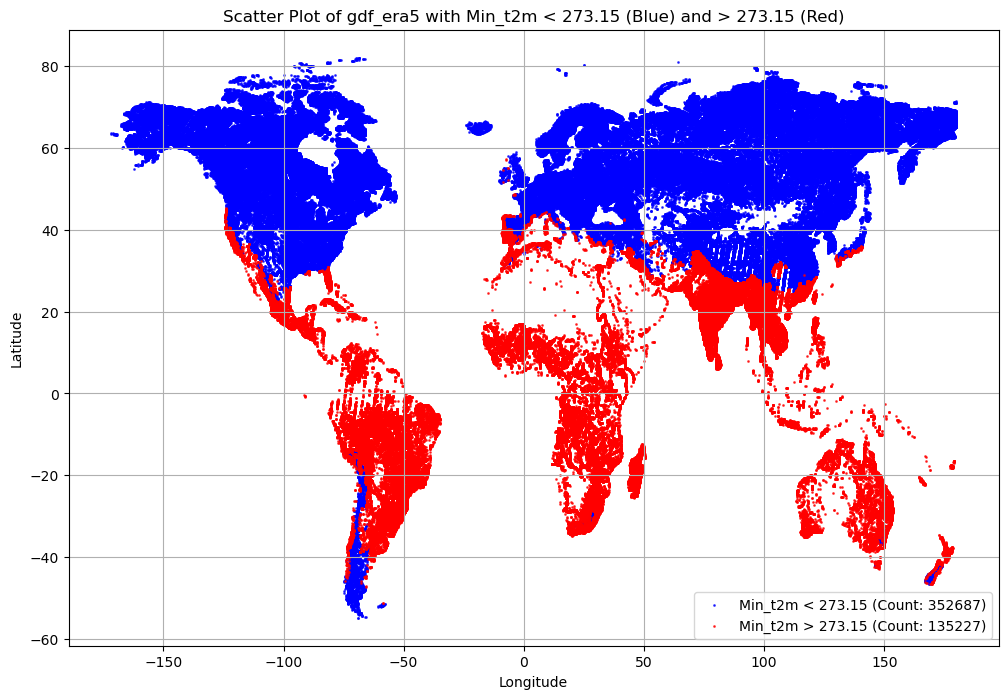

In [14]:
# Define cutoff value
cutoff = 273.15

# Calculate counts for each category
count_below = (gdf_era5['Min_t2m'] < cutoff).sum()
count_above = (gdf_era5['Min_t2m'] > cutoff).sum()

# Print counts
print(f"Count of Min_t2m < {cutoff}: {count_below}")
print(f"Count of Min_t2m > {cutoff}: {count_above}")

# Plot data points with Min_t2m < cutoff in blue
plt.figure(figsize=(12, 8))
plt.scatter(
    gdf_era5[gdf_era5['Min_t2m'] < cutoff]['lon'],
    gdf_era5[gdf_era5['Min_t2m'] < cutoff]['lat'],
    c='blue',
    s=1,
    alpha=0.7,
    label=f'Min_t2m < {cutoff} (Count: {count_below})'
)

# Plot data points with Min_t2m > cutoff in red
plt.scatter(
    gdf_era5[gdf_era5['Min_t2m'] > cutoff]['lon'],
    gdf_era5[gdf_era5['Min_t2m'] > cutoff]['lat'],
    c='red',
    s=1,
    alpha=0.7,
    label=f'Min_t2m > {cutoff} (Count: {count_above})'
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Scatter Plot of gdf_era5 with Min_t2m < {cutoff} (Blue) and > {cutoff} (Red)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
snow_rivers = gdf_era5[gdf_era5['Min_t2m'] < cutoff]['COMID']
non_snow_rivers = gdf_era5[gdf_era5['Min_t2m'] > cutoff]['COMID']

In [16]:
len(snow_rivers.unique())

346828

In [17]:
len(snow_rivers)

352687

## Using snow COMID to filter data and generate Snow and Snowfree data for analysis

In [18]:
# Relaod all of the large or more than 60 count dataset

import pandas as pd
from tqdm import tqdm
base_path = 'ClimateRegionDivision/HUC_Parquet/'

file_names = [f"{i}_large.parquet" for i in range(1, 9)]
huc_dfs = [pd.read_parquet(base_path + file_name) for file_name in tqdm(file_names)]
large_data_region = pd.concat(huc_dfs, ignore_index=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:17<00:00, 17.20s/it]


In [19]:
del huc_dfs

In [20]:
large_data_region

riverID                date       width        lat  \
0           R11000054XS0000001 2017-04-06 04:25:24  284.632214  29.653813   
1           R11000054XS0000003 2017-04-06 04:25:24   94.828588  29.656727   
2           R11000054XS0000001 2017-05-06 04:02:47  316.912003  29.653813   
3           R11000054XS0000002 2017-05-06 04:02:47  327.036912  29.655221   
4           R11000054XS0000003 2017-05-06 04:02:47  132.685949  29.656727   
...                        ...                 ...         ...        ...   
2095626930  R86007272XS4702785 2022-10-03 23:55:57   77.457966  74.453367   
2095626931  R86007272XS4702798 2022-10-03 23:55:57   47.040770  74.456667   
2095626932  R86007272XS4702799 2022-10-03 23:55:57   38.494502  74.456154   
2095626933  R86007272XS4702800 2022-10-03 23:55:57   14.688817  74.455833   
2095626934  R86007272XS4702801 2022-10-03 23:55:57   74.776672  74.455833   

                   lon  sceneID_unique     COMID  month  
0            32.352854           99058  11000054      4  
1            32.352440           99058  11000054      4  
2            32.352854           99061  11000054      5  
3            32.352500           99061  11000054      5  
4            32.352440           99061  11000054      5  
...                ...             ...       ...    ...  
2095626930 -113.406667           11775  86007272     10  
2095626931 -113.359465           11775  86007272     10  
2095626932 -113.356154           11775  86007272     10  
2095626933 -113.352295           11775  86007272     10  
2095626934 -113.347517           11775  86007272     10  

[2095626935 rows x 8 columns]

In [21]:
from datetime import datetime; print(datetime.now())

# Change the data format to YYYY-MM-DD
large_data_region['date'] = pd.to_datetime(large_data_region['date'])
large_data_region['date_YMD'] = large_data_region['date'].dt.strftime('%Y-%m-%d')

2025-01-30 08:50:11.227602


In [22]:
from datetime import datetime; print(datetime.now())

# Change COMID to int
large_data_region['COMID'] = large_data_region['COMID'].astype(int)
large_data_region.columns

2025-01-30 09:08:19.912410


Index(['riverID', 'date', 'width', 'lat', 'lon', 'sceneID_unique', 'COMID',
       'month', 'date_YMD'],
      dtype='object')

In [23]:
snow_rivers = data[['COMID', 'Min_t2m']][data['Min_t2m'] < 273.15]['COMID']

In [24]:
never_snow_rivers = data[['COMID', 'Min_t2m']][data['Min_t2m'] >= 273.15]['COMID']

In [25]:
# Sample testing for 100 -- currently removed
snow_comid = list(snow_rivers.unique()[-100:])
snow_comid = set(snow_rivers.unique())
never_snow_comid = set(never_snow_rivers.unique())

len(snow_comid), len(never_snow_comid)

(346828, 131489)

In [26]:
from datetime import datetime; print(datetime.now())

# Take only rivers that fall at least once into the snow regions
temperature_data = data[data['COMID'].isin(snow_comid)]
# large_data_region_sample = large_data_region[large_data_region['COMID'].isin(snow_comid)]

2025-01-30 09:10:39.811310


In [27]:
# large_data_region_sample_neversnow = large_data_region[~large_data_region['COMID'].isin(snow_comid)]

In [28]:
# # Debug cell

# # Take only rivers that fall at least once into the snow regions
# large_data_region_sample = large_data_region.tail(273391)
# temperature_data = data[data['COMID'].isin(large_data_region_sample['COMID'].unique())]

In [29]:
from datetime import datetime; print(datetime.now())

# Reshape the temperature data for current needs and make it binary
temperature_data.drop(columns=['Min_t2m'], inplace=True)
temperature_data.set_index('COMID', inplace=True)

# temperature_data.columns = pd.to_datetime(temperature_data.columns, errors='coerce', format='%Y-%m-%d')

threshold = 273.15
binary_temperature_data = (temperature_data > threshold).astype(int)
binary_temperature_data = binary_temperature_data.reset_index().melt(
    id_vars='COMID', var_name='date_YMD', value_name='hot_enough'
)

2025-01-30 09:10:40.749961


/tmp/ipykernel_4105428/626702370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data.drop(columns=['Min_t2m'], inplace=True)


In [30]:
large_data_chunk = large_data_region[(large_data_region['COMID'] >= 10000000) & (large_data_region['COMID'] < 15000000)]

In [31]:
binary_temperature_data

COMID    date_YMD  hot_enough
0          12084794  2019-01-01           1
1          12086717  2019-01-01           1
2          12086720  2019-01-01           1
3          12086955  2019-01-01           1
4          12090090  2019-01-01           1
...             ...         ...         ...
761646370  86007034  2022-12-31           0
761646371  86007071  2022-12-31           0
761646372  86007124  2022-12-31           0
761646373  86007168  2022-12-31           0
761646374  86007176  2022-12-31           0

[761646375 rows x 3 columns]

In [32]:
chunk_warmcheck = []

for comid_min in tqdm(range(10000000, 90000000, 5000000)):
    comid_max = comid_min + 5000000

    temperature_chunk = binary_temperature_data[(binary_temperature_data['COMID'] >= comid_min) & (binary_temperature_data['COMID'] < comid_max)]
    large_data_chunk = large_data_region[(large_data_region['COMID'] >= comid_min) & (large_data_region['COMID'] < comid_max)]

    large_data_chunk = large_data_chunk[large_data_chunk['COMID'].isin(temperature_chunk['COMID'].unique())]
    large_chunk_warmcheck = pd.merge(
        large_data_chunk, 
        temperature_chunk, 
        on=['COMID', 'date_YMD'], 
        how='left'
    )
    chunk_warmcheck.append(large_chunk_warmcheck)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [11:11<00:00, 41.95s/it]


In [33]:
final_large_data_warm = pd.concat(chunk_warmcheck, ignore_index=True)

In [34]:
final_large_data_warm

riverID                date      width        lat  \
0           R12084791XS2389944 2019-01-12 10:09:57   8.448136 -28.952676   
1           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
2           R12084791XS2389944 2019-01-12 10:09:57  10.141748 -28.952676   
3           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
4           R12084791XS2389910 2019-02-06 10:50:10  21.861701 -28.965000   
...                        ...                 ...        ...        ...   
1192423401  R86007272XS4702785 2022-10-03 23:55:57  77.457966  74.453367   
1192423402  R86007272XS4702798 2022-10-03 23:55:57  47.040770  74.456667   
1192423403  R86007272XS4702799 2022-10-03 23:55:57  38.494502  74.456154   
1192423404  R86007272XS4702800 2022-10-03 23:55:57  14.688817  74.455833   
1192423405  R86007272XS4702801 2022-10-03 23:55:57  74.776672  74.455833   

                   lon  sceneID_unique     COMID  month    date_YMD  \
0            27.725176           95294  12084791      1  2019-01-12   
1            27.724663           95294  12084791      1  2019-01-12   
2            27.725176           95295  12084791      1  2019-01-12   
3            27.724663           95295  12084791      1  2019-01-12   
4            27.723562           95361  12084791      2  2019-02-06   
...                ...             ...       ...    ...         ...   
1192423401 -113.406667           11775  86007272     10  2022-10-03   
1192423402 -113.359465           11775  86007272     10  2022-10-03   
1192423403 -113.356154           11775  86007272     10  2022-10-03   
1192423404 -113.352295           11775  86007272     10  2022-10-03   
1192423405 -113.347517           11775  86007272     10  2022-10-03   

            hot_enough  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
1192423401         0.0  
1192423402         0.0  
1192423403         0.0  
1192423404         0.0  
1192423405         0.0  

[1192423406 rows x 10 columns]

In [35]:
final_large_data_warm = final_large_data_warm[final_large_data_warm['hot_enough'] == 1]

In [36]:
never_snow_large_data = []

for comid_min in tqdm(range(10000000, 90000000, 5000000)):
    comid_max = comid_min + 5000000

    large_data_chunk = large_data_region[(large_data_region['COMID'] >= comid_min) & (large_data_region['COMID'] < comid_max)]
    large_data_chunk = large_data_chunk[large_data_chunk['COMID'].isin(never_snow_comid)]
    never_snow_large_data.append(large_data_chunk[large_data_chunk['COMID'].isin(never_snow_comid)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:58<00:00, 14.92s/it]


In [37]:
never_snow_regons_merged = pd.concat(never_snow_large_data, ignore_index=True)

In [38]:
never_snow_regons_merged

riverID                date       width        lat  \
0          R11000054XS0000001 2017-04-06 04:25:24  284.632214  29.653813   
1          R11000054XS0000003 2017-04-06 04:25:24   94.828588  29.656727   
2          R11000054XS0000001 2017-05-06 04:02:47  316.912003  29.653813   
3          R11000054XS0000002 2017-05-06 04:02:47  327.036912  29.655221   
4          R11000054XS0000003 2017-05-06 04:02:47  132.685949  29.656727   
...                       ...                 ...         ...        ...   
559559594  R78027927XS0147569 2022-12-06 21:50:59   22.856135  42.185966   
559559595  R78027927XS0147569 2022-12-13 22:25:00   82.885030  42.185966   
559559596  R78027927XS0147570 2022-12-13 22:25:00   34.744213  42.186366   
559559597  R78027927XS0147569 2022-12-16 22:22:55   58.222716  42.185966   
559559598  R78027927XS0147570 2022-12-16 22:22:55    6.303858  42.186366   

                  lon  sceneID_unique     COMID  month    date_YMD  
0           32.352854           99058  11000054      4  2017-04-06  
1           32.352440           99058  11000054      4  2017-04-06  
2           32.352854           99061  11000054      5  2017-05-06  
3           32.352500           99061  11000054      5  2017-05-06  
4           32.352440           99061  11000054      5  2017-05-06  
...               ...             ...       ...    ...         ...  
559559594 -124.134868           33477  78027927     12  2022-12-06  
559559595 -124.134868           33484  78027927     12  2022-12-13  
559559596 -124.134467           33484  78027927     12  2022-12-13  
559559597 -124.134868           33498  78027927     12  2022-12-16  
559559598 -124.134467           33498  78027927     12  2022-12-16  

[559559599 rows x 9 columns]

In [39]:
# Idk if i should merge the data here, looks like i should not. just kep the backup data ion hand and let the raw data flow through. also make sure that the stats are calculated

#### too much ram being consumed so ill delete the main large_data_region

In [40]:
# del large_data_region

In [41]:
final_large_data_warm

riverID                date       width        lat  \
0           R12084791XS2389944 2019-01-12 10:09:57    8.448136 -28.952676   
1           R12084791XS2389945 2019-01-12 10:09:57    1.586848 -28.952500   
2           R12084791XS2389944 2019-01-12 10:09:57   10.141748 -28.952676   
3           R12084791XS2389945 2019-01-12 10:09:57    1.586848 -28.952500   
4           R12084791XS2389910 2019-02-06 10:50:10   21.861701 -28.965000   
...                        ...                 ...         ...        ...   
1192423209  R86007272XS4702789 2022-08-30 02:46:01  174.460430  74.455969   
1192423210  R86007272XS4702791 2022-08-30 02:46:01  203.595492  74.456667   
1192423211  R86007272XS4702792 2022-08-30 02:46:01  192.266348  74.456667   
1192423212  R86007272XS4702795 2022-08-30 02:46:01  116.841376  74.457500   
1192423213  R86007272XS4702811 2022-08-30 02:46:01  196.517060  74.452500   

                   lon  sceneID_unique     COMID  month    date_YMD  \
0            27.725176           95294  12084791      1  2019-01-12   
1            27.724663           95294  12084791      1  2019-01-12   
2            27.725176           95295  12084791      1  2019-01-12   
3            27.724663           95295  12084791      1  2019-01-12   
4            27.723562           95361  12084791      2  2019-02-06   
...                ...             ...       ...    ...         ...   
1192423209 -113.395698           11485  86007272      8  2022-08-30   
1192423210 -113.388139           11485  86007272      8  2022-08-30   
1192423211 -113.383362           11485  86007272      8  2022-08-30   
1192423212 -113.371413           11485  86007272      8  2022-08-30   
1192423213 -113.314054           11485  86007272      8  2022-08-30   

            hot_enough  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
1192423209         1.0  
1192423210         1.0  
1192423211         1.0  
1192423212         1.0  
1192423213         1.0  

[841239265 rows x 10 columns]

#### now merge these two

In [42]:
never_snow_regons_merged['hot_enough'] = 1.0

In [43]:
# Concatenate the two DataFrames
final_warm_plus_neversnow_merged = pd.concat(
    [final_large_data_warm, never_snow_regons_merged],
    axis=0,  # Stack vertically
    ignore_index=True  # Reset the index
)


In [44]:
never_snow_regons_merged

riverID                date       width        lat  \
0          R11000054XS0000001 2017-04-06 04:25:24  284.632214  29.653813   
1          R11000054XS0000003 2017-04-06 04:25:24   94.828588  29.656727   
2          R11000054XS0000001 2017-05-06 04:02:47  316.912003  29.653813   
3          R11000054XS0000002 2017-05-06 04:02:47  327.036912  29.655221   
4          R11000054XS0000003 2017-05-06 04:02:47  132.685949  29.656727   
...                       ...                 ...         ...        ...   
559559594  R78027927XS0147569 2022-12-06 21:50:59   22.856135  42.185966   
559559595  R78027927XS0147569 2022-12-13 22:25:00   82.885030  42.185966   
559559596  R78027927XS0147570 2022-12-13 22:25:00   34.744213  42.186366   
559559597  R78027927XS0147569 2022-12-16 22:22:55   58.222716  42.185966   
559559598  R78027927XS0147570 2022-12-16 22:22:55    6.303858  42.186366   

                  lon  sceneID_unique     COMID  month    date_YMD  hot_enough  
0           32.352854           99058  11000054      4  2017-04-06         1.0  
1           32.352440           99058  11000054      4  2017-04-06         1.0  
2           32.352854           99061  11000054      5  2017-05-06         1.0  
3           32.352500           99061  11000054      5  2017-05-06         1.0  
4           32.352440           99061  11000054      5  2017-05-06         1.0  
...               ...             ...       ...    ...         ...         ...  
559559594 -124.134868           33477  78027927     12  2022-12-06         1.0  
559559595 -124.134868           33484  78027927     12  2022-12-13         1.0  
559559596 -124.134467           33484  78027927     12  2022-12-13         1.0  
559559597 -124.134868           33498  78027927     12  2022-12-16         1.0  
559559598 -124.134467           33498  78027927     12  2022-12-16         1.0  

[559559599 rows x 10 columns]

In [45]:
final_warm_plus_neversnow_merged.shape

(1400798864, 10)

In [46]:
final_large_data_warm.shape

(841239265, 10)

In [47]:
never_snow_regons_merged.shape

(559559599, 10)

In [48]:
# Compute the intersections
intersection_snow = set(final_warm_plus_neversnow_merged['COMID']).intersection(snow_comid)
intersection_never_snow = set(final_warm_plus_neversnow_merged['COMID']).intersection(never_snow_comid)

# Output the number of intersections
print(f"Number of intersections with snow_comid: {len(intersection_snow)}")
print(f"Number of intersections with never_snow_comid: {len(intersection_never_snow)}")

Number of intersections with snow_comid: 346825
Number of intersections with never_snow_comid: 131489


In [49]:
# COLD ONLY

In [50]:
final_large_data_warm.shape

(841239265, 10)

In [51]:
output_path = 'ClimateRegionDivision/HUC_Parquet/coldRegion_large_T273check.parquet'
final_large_data_warm.to_parquet(output_path, index=False)

In [52]:
final_large_data_warm_COLDONLY_over60 = final_large_data_warm[final_large_data_warm['COMID'].map(final_large_data_warm['COMID'].value_counts()) >= 60]

In [53]:
output_path = 'ClimateRegionDivision/HUC_Parquet/coldRegion_large_T273check_over60.parquet'
final_large_data_warm_COLDONLY_over60.to_parquet(output_path, index=False)

In [54]:
# COLD AND WARM

In [55]:
final_warm_plus_neversnow_merged.shape

(1400798864, 10)

In [56]:
output_path = 'ClimateRegionDivision/HUC_Parquet/allRegion_large_T273check.parquet'
final_warm_plus_neversnow_merged.to_parquet(output_path, index=False)

In [57]:
final_large_data_warm_over60 = final_warm_plus_neversnow_merged[final_warm_plus_neversnow_merged['COMID'].map(final_warm_plus_neversnow_merged['COMID'].value_counts()) >= 60]

In [58]:
output_path = 'ClimateRegionDivision/HUC_Parquet/allRegion_large_T273check_over60.parquet'
final_large_data_warm_over60.to_parquet(output_path, index=False)

In [59]:
import requests

def send_ntfy_notification(title, message, priority="urgent", tags="bell,fire"):
    url = "https://ntfy.sh/river_width_res"
    headers = {
        "Title": title,
        "Priority": priority,
        "Tags": tags
    }
    response = requests.post(url, data=message, headers=headers)
    return response

# Example usage after a cell completes
send_ntfy_notification(
    title="Notebook Alert: Cell Execution Complete",
    message="Your cell has successfully completed execution!",
    priority="urgent",
    tags="bell,fire"
)

<Response [200]>

## Count number of observations for each comid for summary

In [60]:
comid_counter_results = []

# Loop through the COMID range in chunks
for comid_min in tqdm(range(10000000, 90000000, 5000000)):
    comid_max = comid_min + 5000000
    
    # Filter the chunk of data
    large_data_chunk = final_large_data_warm_over60[
        (final_large_data_warm_over60['COMID'] >= comid_min) &
        (final_large_data_warm_over60['COMID'] < comid_max)
    ]
    
    # Group by COMID and count rows
    comid_counts = large_data_chunk.groupby('COMID').size().reset_index(name='count_of_rows')

    # Merge the two DataFrames on the 'COMID' column
    final_comid_count_result = pd.merge(
        comid_counts, 
        MERIT_df[['COMID', 'order']], 
        how='inner',  # Use 'inner' join to include only matching COMID
        on='COMID'    # Column to join on
    )
    
    # Append results
    comid_counter_results.append(final_comid_count_result)

# Combine all chunks into a single DataFrame
final_comid_counts = pd.concat(comid_counter_results, ignore_index=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:31<00:00,  9.49s/it]


In [61]:
final_comid_counts['order'].value_counts()

order
1    156573
2     89867
4     75507
3     69492
5     49757
6     23386
7      8574
8      2994
9        96
Name: count, dtype: int64

In [62]:
# Step 1: Group by 'order' and calculate unique COMID count and total count of rows
order_stats = final_comid_counts.groupby('order').agg(
    unique_comid_count=('COMID', 'nunique'),
    total_count_of_rows=('count_of_rows', 'sum')
).reset_index()

# Step 2: Merge stats for orders >= 8 into a single row
order_stats['order'] = order_stats['order'].apply(lambda x: '>=8' if x >= 8 else x)

# Step 3: Group again to consolidate merged orders
final_order_stats = order_stats.groupby('order').agg(
    unique_comid_count=('unique_comid_count', 'sum'),
    total_count_of_rows=('total_count_of_rows', 'sum')
).reset_index()

# Step 4: Create lists for unique_comid_count and total_count_of_rows
unique_comid_count_list = final_order_stats['unique_comid_count'].tolist()
total_count_of_rows_list = final_order_stats['total_count_of_rows'].tolist()

# Print final results
print(final_order_stats)
print("Unique COMID count list:", unique_comid_count_list)
print("Total count of rows list:", total_count_of_rows_list)

  order  unique_comid_count  total_count_of_rows
0     1              156573            224586683
1     2               89867            176659011
2     3               69492            219774726
3     4               75507            336281066
4     5               49757            262838147
5     6               23386            121567602
6     7                8574             42159967
7   >=8                3090             16847803
Unique COMID count list: [156573, 89867, 69492, 75507, 49757, 23386, 8574, 3090]
Total count of rows list: [224586683, 176659011, 219774726, 336281066, 262838147, 121567602, 42159967, 16847803]


In [63]:
np.sum(unique_comid_count_list)

476246

In [64]:
np.sum(total_count_of_rows_list)

1400715005

In [65]:
final_large_data_warm_over60

riverID                date      width        lat  \
0           R12084791XS2389944 2019-01-12 10:09:57   8.448136 -28.952676   
1           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
2           R12084791XS2389944 2019-01-12 10:09:57  10.141748 -28.952676   
3           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
4           R12084791XS2389910 2019-02-06 10:50:10  21.861701 -28.965000   
...                        ...                 ...        ...        ...   
1400798859  R78027927XS0147569 2022-12-06 21:50:59  22.856135  42.185966   
1400798860  R78027927XS0147569 2022-12-13 22:25:00  82.885030  42.185966   
1400798861  R78027927XS0147570 2022-12-13 22:25:00  34.744213  42.186366   
1400798862  R78027927XS0147569 2022-12-16 22:22:55  58.222716  42.185966   
1400798863  R78027927XS0147570 2022-12-16 22:22:55   6.303858  42.186366   

                   lon  sceneID_unique     COMID  month    date_YMD  \
0            27.725176           95294  12084791      1  2019-01-12   
1            27.724663           95294  12084791      1  2019-01-12   
2            27.725176           95295  12084791      1  2019-01-12   
3            27.724663           95295  12084791      1  2019-01-12   
4            27.723562           95361  12084791      2  2019-02-06   
...                ...             ...       ...    ...         ...   
1400798859 -124.134868           33477  78027927     12  2022-12-06   
1400798860 -124.134868           33484  78027927     12  2022-12-13   
1400798861 -124.134467           33484  78027927     12  2022-12-13   
1400798862 -124.134868           33498  78027927     12  2022-12-16   
1400798863 -124.134467           33498  78027927     12  2022-12-16   

            hot_enough  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
1400798859         1.0  
1400798860         1.0  
1400798861         1.0  
1400798862         1.0  
1400798863         1.0  

[1400715005 rows x 10 columns]

In [66]:
del final_large_data_warm
#del never_snow_regons_merged

In [67]:
del final_warm_plus_neversnow_merged

## Conduct width comparision analysis

In [68]:
import pandas as pd

In [69]:
output_path = 'ClimateRegionDivision/HUC_Parquet/allRegion_large_T273check_over60.parquet'
final_large_data_warm_over60 = pd.read_parquet(output_path)


In [70]:
final_large_data_warm_over60

riverID                date      width        lat  \
0           R12084791XS2389944 2019-01-12 10:09:57   8.448136 -28.952676   
1           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
2           R12084791XS2389944 2019-01-12 10:09:57  10.141748 -28.952676   
3           R12084791XS2389945 2019-01-12 10:09:57   1.586848 -28.952500   
4           R12084791XS2389910 2019-02-06 10:50:10  21.861701 -28.965000   
...                        ...                 ...        ...        ...   
1400715000  R78027927XS0147569 2022-12-06 21:50:59  22.856135  42.185966   
1400715001  R78027927XS0147569 2022-12-13 22:25:00  82.885030  42.185966   
1400715002  R78027927XS0147570 2022-12-13 22:25:00  34.744213  42.186366   
1400715003  R78027927XS0147569 2022-12-16 22:22:55  58.222716  42.185966   
1400715004  R78027927XS0147570 2022-12-16 22:22:55   6.303858  42.186366   

                   lon  sceneID_unique     COMID  month    date_YMD  \
0            27.725176           95294  12084791      1  2019-01-12   
1            27.724663           95294  12084791      1  2019-01-12   
2            27.725176           95295  12084791      1  2019-01-12   
3            27.724663           95295  12084791      1  2019-01-12   
4            27.723562           95361  12084791      2  2019-02-06   
...                ...             ...       ...    ...         ...   
1400715000 -124.134868           33477  78027927     12  2022-12-06   
1400715001 -124.134868           33484  78027927     12  2022-12-13   
1400715002 -124.134467           33484  78027927     12  2022-12-13   
1400715003 -124.134868           33498  78027927     12  2022-12-16   
1400715004 -124.134467           33498  78027927     12  2022-12-16   

            hot_enough  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
1400715000         1.0  
1400715001         1.0  
1400715002         1.0  
1400715003         1.0  
1400715004         1.0  

[1400715005 rows x 10 columns]

### Got final_large_data_warm_over60 for the non snow covered area, with original data ⍟⍟⍟

In [71]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from shapely.geometry import Point

# Paths to the shapefiles
lakes_shapefile_path = 'ClimateRegionDivision/HUC_Parquet/Large lakes 5km2 and Coastlunes/Large Hydrolakes 5km2.shp'
coastline_shapefile_path = "ClimateRegionDivision/HUC_Parquet/Large lakes 5km2 and Coastlunes/GSHHS_f_L1.shp"

# Initialize an empty list to store DataFrames
points_dataframes = []

# Load and concatenate parquet files XS_GLOW_GLOWS_1 to XS_GLOW_GLOWS_8
for i in tqdm(range(1, 9)):
    file_path = f"ClimateRegionDivision/HUC_Parquet/XS_GLOW_GLOWS_{i}.parquet"
    points_df = pd.read_parquet(file_path)
    points_dataframes.append(points_df)

# Concatenate all DataFrames into a single DataFrame
points_df = pd.concat(points_dataframes, ignore_index=True)

# Convert points DataFrame to GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    points_df, 
    geometry=[Point(xy) for xy in zip(points_df.lon, points_df.lat)],
    crs="EPSG:4326"  # Assuming the coordinate system is WGS84
)

print('Loaded shapefile and parquet files')

# Load the lakes shapefile
lakes_gdf = gpd.read_file(lakes_shapefile_path)

# Load the coastline shapefile
coastline_gdf = gpd.read_file(coastline_shapefile_path)

# Ensure both GeoDataFrames have the same CRS as the points
lakes_gdf = lakes_gdf.to_crs(points_gdf.crs)
coastline_gdf = coastline_gdf.to_crs(points_gdf.crs)

# Perform a spatial join to find points within lakes
points_within_lakes = gpd.sjoin(points_gdf, lakes_gdf, op='within')

# Inverse the spatial join result to get points outside lakes (on land)
points_outside_lakes = points_gdf[~points_gdf.index.isin(points_within_lakes.index)]

# Now perform a spatial join to find points that fall within the coastline features
points_within_coastline = gpd.sjoin(points_outside_lakes, coastline_gdf, op='within')

# Filter points to keep only those that fall within the coastline features
# This ensures that the points are both outside lakes and within coastline features (land)
points_on_land = points_within_coastline

# Assign region based on 'riverID' by extracting the second character and converting to integer
points_on_land['region'] = points_on_land['riverID'].str[1].astype(int)

# Display the number of points within the coastline features
points_on_land_count = points_on_land.shape[0]

print(f"Points on land (inside coastline features): {points_on_land_count}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.62s/it]


Loaded shapefile and parquet files


/N/lustre/project/proj-212/conda_env/clusterGIS/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/N/lustre/project/proj-212/conda_env/clusterGIS/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Points on land (inside coastline features): 17621777


In [72]:
points_on_land['COMID'] = points_on_land['ID_unique'].str.extract(r'R(\d+)XS')

In [73]:
# get comid of points in land of glow vs sari
COMID_we_have = set([int(i) for i in points_on_land['COMID'].unique()])

In [74]:
len(COMID_we_have)

201186

In [75]:
final_large_data_warm_over60_inCOMID = final_large_data_warm_over60[final_large_data_warm_over60['COMID'].isin(COMID_we_have)]

In [76]:
final_large_data_warm_over60_inCOMID

riverID                date       width        lat  \
26456       R12085228XS0197015 2018-12-23 10:04:43   54.604434 -28.991392   
26457       R12085228XS0197016 2018-12-23 10:04:43  289.910975 -28.993070   
26458       R12085228XS0197017 2018-12-23 10:04:43  167.159573 -28.994839   
26459       R12085228XS0197015 2018-12-23 10:04:43   54.604434 -28.991392   
26460       R12085228XS0197016 2018-12-23 10:04:43  289.910975 -28.993070   
...                        ...                 ...         ...        ...   
1400607775  R78025820XS2408976 2022-12-16 22:22:55  160.076757  43.146697   
1400607776  R78025820XS2408977 2022-12-16 22:22:55  138.041156  43.145032   
1400607777  R78025820XS2408978 2022-12-16 22:22:55  100.846374  43.143520   
1400607778  R78025820XS2408979 2022-12-16 22:22:55  121.050248  43.141899   
1400607779  R78025820XS2408980 2022-12-16 22:22:55  136.186067  43.140349   

                   lon  sceneID_unique     COMID  month    date_YMD  \
26456        28.142225           95251  12085228     12  2018-12-23   
26457        28.142500           95251  12085228     12  2018-12-23   
26458        28.142500           95251  12085228     12  2018-12-23   
26459        28.142225           95252  12085228     12  2018-12-23   
26460        28.142500           95252  12085228     12  2018-12-23   
...                ...             ...       ...    ...         ...   
1400607775 -124.340833           51309  78025820     12  2022-12-16   
1400607776 -124.340833           51309  78025820     12  2022-12-16   
1400607777 -124.341480           51309  78025820     12  2022-12-16   
1400607778 -124.341667           51309  78025820     12  2022-12-16   
1400607779 -124.341183           51309  78025820     12  2022-12-16   

            hot_enough  
26456              1.0  
26457              1.0  
26458              1.0  
26459              1.0  
26460              1.0  
...                ...  
1400607775         1.0  
1400607776         1.0  
1400607777         1.0  
1400607778         1.0  
1400607779         1.0  

[577573402 rows x 10 columns]

In [77]:
points_on_land.head(3)

riverID      date_x     width_x                       ID_date  \
0  R13025101XS0298555  2020-04-10  292.230815  R13025101XS02985552020-04-10   
1  R13025101XS0298556  2020-04-10  281.350696  R13025101XS02985562020-04-10   
2  R13025102XS0298559  2020-04-10  276.779041  R13025102XS02985592020-04-10   

                   ID     date_y     width_y        lon       lat  \
0  R13025101XS0298555 2020-04-10  274.819575  16.081667  2.193528   
1  R13025101XS0298556 2020-04-10  259.474668  16.082323  2.194823   
2  R13025102XS0298559 2020-04-10  484.971839  16.091150  2.202500   

            ID_unique                  geometry  index_right id  level source  \
0  R13025101XS0298555  POINT (16.08167 2.19353)            2  1      1    WVS   
1  R13025101XS0298556  POINT (16.08232 2.19482)            2  1      1    WVS   
2  R13025102XS0298559  POINT (16.09115 2.20250)            2  1      1    WVS   

   parent_id  sibling_id          area  region     COMID  
0         -1          -1  2.922097e+07       1  13025101  
1         -1          -1  2.922097e+07       1  13025101  
2         -1          -1  2.922097e+07       1  13025102

In [78]:
# Rename date_x to date_YMD to merge
# Convert COMID to int

points_on_land = points_on_land.rename(columns={'date_x': 'date_YMD'})
points_on_land['COMID'] = points_on_land['COMID'].astype(int)


In [79]:
final_large_data_warm_over60['ID_date'] = final_large_data_warm_over60['riverID'] + final_large_data_warm_over60['date_YMD']

In [80]:
points_on_land.shape, final_large_data_warm_over60.shape

((17621777, 20), (1400715005, 11))

In [81]:
final_large_data_warm_over60_inCOMID_land = pd.merge(
    points_on_land,
    final_large_data_warm_over60[['COMID','date_YMD', 'ID_date', 'hot_enough']],
    on=['ID_date'],
    how='inner'  # Change to 'left' or 'right' if needed
)


In [82]:
1

1

In [83]:
final_large_data_warm_over60_inCOMID_land

riverID  date_YMD_x     width_x  \
0         R14051782XS0626249  2019-01-01  141.931426   
1         R14051782XS0626251  2019-01-01   78.694621   
2         R14051782XS0626252  2019-01-01   66.389825   
3         R14051782XS0626253  2019-01-01   80.097630   
4         R14051782XS0626255  2019-01-01   66.200698   
...                      ...         ...         ...   
25186686  R77043524XS2176876  2020-09-11  409.711327   
25186687  R77043524XS2176876  2020-09-11  409.711327   
25186688  R77043524XS2176876  2020-09-11  409.166865   
25186689  R77043524XS2176876  2020-09-11  409.166865   
25186690  R77043524XS2176876  2020-11-30  404.430697   

                               ID_date                  ID     date_y  \
0         R14051782XS06262492019-01-01  R14051782XS0626249 2019-01-01   
1         R14051782XS06262512019-01-01  R14051782XS0626251 2019-01-01   
2         R14051782XS06262522019-01-01  R14051782XS0626252 2019-01-01   
3         R14051782XS06262532019-01-01  R14051782XS0626253 2019-01-01   
4         R14051782XS06262552019-01-01  R14051782XS0626255 2019-01-01   
...                                ...                 ...        ...   
25186686  R77043524XS21768762020-09-11  R77043524XS2176876 2020-09-11   
25186687  R77043524XS21768762020-09-11  R77043524XS2176876 2020-09-11   
25186688  R77043524XS21768762020-09-11  R77043524XS2176876 2020-09-11   
25186689  R77043524XS21768762020-09-11  R77043524XS2176876 2020-09-11   
25186690  R77043524XS21768762020-11-30  R77043524XS2176876 2020-11-30   

             width_y         lon        lat           ID_unique  ... level  \
0         158.606792    4.735846  10.665000  R14051782XS0626249  ...     1   
1          56.781502    4.743792  10.667500  R14051782XS0626251  ...     1   
2          60.172900    4.747563  10.667437  R14051782XS0626252  ...     1   
3          90.259349    4.751739  10.666667  R14051782XS0626253  ...     1   
4          63.467095    4.759187  10.665854  R14051782XS0626255  ...     1   
...              ...         ...        ...                 ...  ...   ...   
25186686  443.101759 -112.101512  25.253179  R77043524XS2176876  ...     1   
25186687  443.101759 -112.101512  25.253179  R77043524XS2176876  ...     1   
25186688  443.101759 -112.101512  25.253179  R77043524XS2176876  ...     1   
25186689  443.101759 -112.101512  25.253179  R77043524XS2176876  ...     1   
25186690  446.620333 -112.101512  25.253179  R77043524XS2176876  ...     1   

          source parent_id  sibling_id          area  region   COMID_x  \
0            WVS        -1          -1  2.922097e+07       1  14051782   
1            WVS        -1          -1  2.922097e+07       1  14051782   
2            WVS        -1          -1  2.922097e+07       1  14051782   
3            WVS        -1          -1  2.922097e+07       1  14051782   
4            WVS        -1          -1  2.922097e+07       1  14051782   
...          ...       ...         ...           ...     ...       ...   
25186686     WVS        -1          -1  3.339402e+00       7  77043524   
25186687     WVS        -1          -1  3.339402e+00       7  77043524   
25186688     WVS        -1          -1  3.339402e+00       7  77043524   
25186689     WVS        -1          -1  3.339402e+00       7  77043524   
25186690     WVS        -1          -1  3.339402e+00       7  77043524   

           COMID_y  date_YMD_y  hot_enough  
0         14051782  2019-01-01         1.0  
1         14051782  2019-01-01         1.0  
2         14051782  2019-01-01         1.0  
3         14051782  2019-01-01         1.0  
4         14051782  2019-01-01         1.0  
...            ...         ...         ...  
25186686  77043524  2020-09-11         1.0  
25186687  77043524  2020-09-11         1.0  
25186688  77043524  2020-09-11         1.0  
25186689  77043524  2020-09-11         1.0  
25186690  77043524  2020-11-30         1.0  

[25186691 rows x 23 columns]

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import numpy as np
from scipy.stats import linregress

# Example data for demonstration (replace with actual data)
x = final_large_data_warm_over60_inCOMID_land['width_x']
y = final_large_data_warm_over60_inCOMID_land['width_y']


In [242]:
final_large_data_warm_over60_inCOMID_land.columns

Index(['riverID', 'date_YMD_x', 'width_x', 'ID_date', 'ID', 'date_y',
       'width_y', 'lon', 'lat', 'ID_unique', 'geometry', 'index_right', 'id',
       'level', 'source', 'parent_id', 'sibling_id', 'area', 'region',
       'COMID_x', 'COMID_y', 'date_YMD_y', 'hot_enough', 'absdifference'],
      dtype='object')

In [85]:
import statistics
std_dev = np.std(x, ddof=1)  # Use ddof=1 for sample standard deviation
std_dev

252.57941724759493

In [86]:
import statistics
std_dev = np.std(y, ddof=1)  # Use ddof=1 for sample standard deviation
std_dev

268.89759946442757

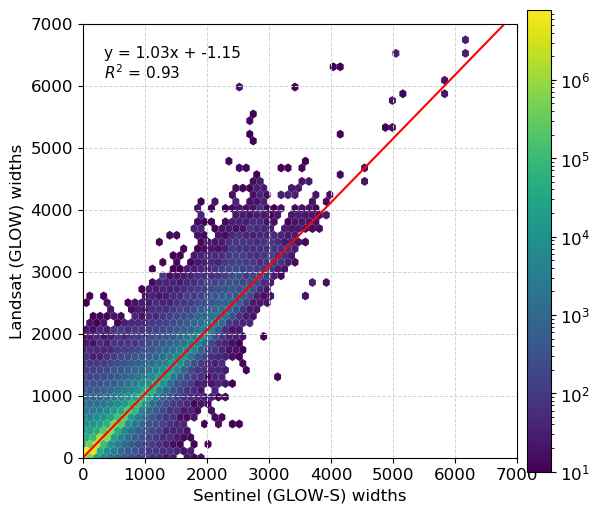

In [87]:
# Create a normal plot (non-log)
fig, ax = plt.subplots(figsize=(6.75, 6))

# Hexbin plot with a logarithmic color scale for better representation of lower value density
hb = ax.hexbin(x, y, gridsize=75, cmap='viridis', mincnt=10, edgecolors='none', norm=LogNorm())

# Add color bar
cb = plt.colorbar(hb, ax=ax, pad=0.02)
cb.ax.tick_params(labelsize=12)

# Perform linear regression on the original x, y data
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Define points for the regression line within the specified range
x_regression_points = np.array([0, 7000])
y_regression_points = slope * x_regression_points + intercept

# Plot the regression line
ax.plot(x_regression_points, y_regression_points, color='red', linewidth=1.5)
ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top', color='black')

# Add labels and title
ax.set_xlabel('Sentinel (GLOW-S) widths', fontsize=12, fontname='sans-serif')
ax.set_ylabel('Landsat (GLOW) widths', fontsize=12, fontname='sans-serif')

# Set equal scaling, limits, and grid
ax.set_xlim(0, 7000)  # Limit x-axis range
ax.set_ylim(0, 7000)  # Limit y-axis range
ax.set_aspect('equal', adjustable='box')
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='lightgray')

# Set locators for clearer intervals
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

# Customize tick parameters and add legend
ax.tick_params(axis='both', which='major', labelsize=12)

# Show plot
plt.show()


In [232]:
# Compute teh difference in GLOW-S and GLOW widths
diff_widths = np.abs(x - y)
sr = np.sort(diff_widths)
Pr = np.arange(1,len(sr)+1)/len(sr)
np.percentile(sr, 99.5)
len(np.nonzero(x<2000)[0])/len(x)

0.9983322938293085

29.828084048517525
2.6537609401688655
-13.471699763799165
-8.891797722782172
-3.8307311797936165


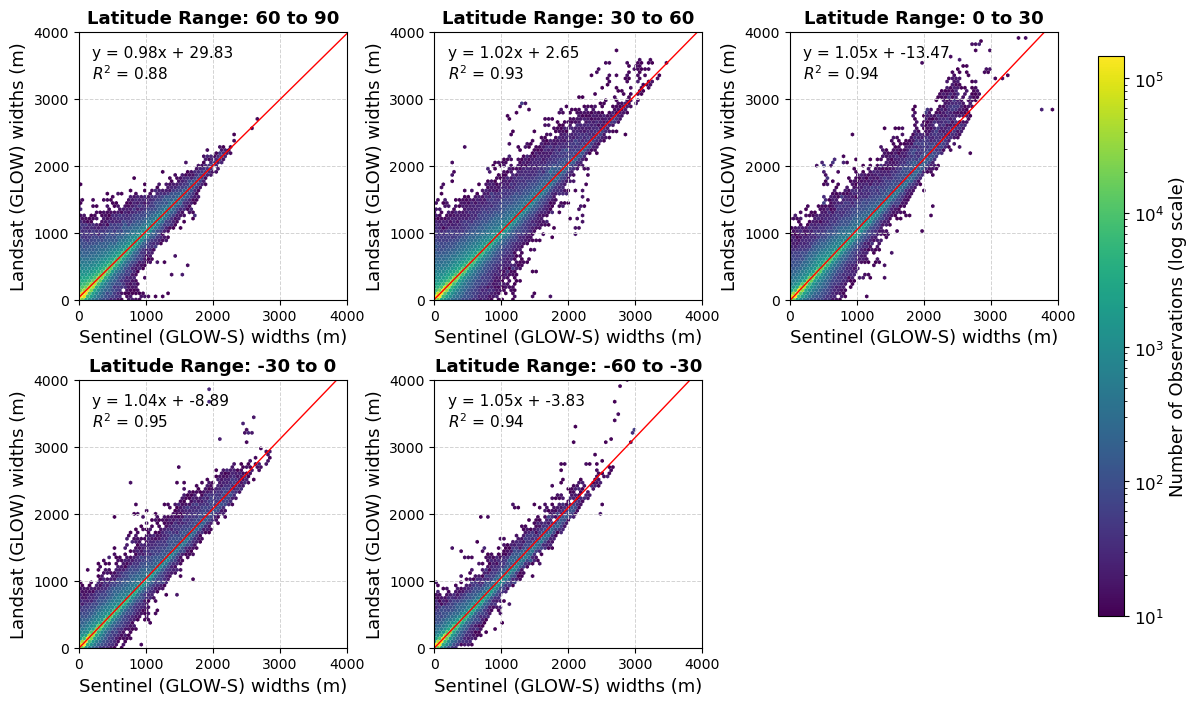

In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import numpy as np
from scipy.stats import linregress

# Latitude ranges to filter data
lat_ranges = [(60, 90), (30, 60), (0, 30), (-30, 0), (-60, -30)]
range_labels = ['60 to 90', '30 to 60', '0 to 30', '-30 to 0', '-60 to -30']

# Create a 2x3 grid for subplots (5 plots)
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
axes = axes.ravel()  # Flatten to easily iterate

# Set global x and y axis limits
x_lim = (0, 4000)
y_lim = (0, 4000)

# Iterate over latitude ranges and plot
for i, lat_range in enumerate(lat_ranges):
    # Filter data within the current latitude range
    filtered_data = final_large_data_warm_over60_inCOMID_land[(final_large_data_warm_over60_inCOMID_land['lat'] >= lat_range[0]) & 
                                                               (final_large_data_warm_over60_inCOMID_land['lat'] < lat_range[1])]
    
    x_widths = filtered_data['width_x']
    y_widths = filtered_data['width_y']
    
    # Perform linear regression on filtered data
    slope, intercept, r_value, p_value, std_err = linregress(x_widths, y_widths)
    x_reg_line_points = np.array([0, 4000])
    y_reg_line_points = slope * x_reg_line_points + intercept
    
    # Plot the hexbin plot on the current axis
    ax = axes[i]
    hb = ax.hexbin(x_widths, y_widths, gridsize=75, extent=[0, 4000, 0, 4000], cmap='viridis', mincnt=10, edgecolors='none', norm=LogNorm())
    
    # Plot the regression line
    print(intercept)
    if intercept > 0:
        ax.plot(x_reg_line_points, y_reg_line_points, color='red', linewidth=1, 
                label=f'Regression: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}')
    else:
        ax.plot(x_reg_line_points, y_reg_line_points, color='red', linewidth=1, 
                label=f'Regression: y = {slope:.2f}x - {abs(intercept):.2f}\n$R^2$ = {r_value**2:.2f}')
    
    
    # Add regression equation as text within the plot
    ax.text(0.05, 0.95, f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}',
            transform=ax.transAxes, fontsize=11, verticalalignment='top', color='black')
    
    # Add title and set aspect
    ax.set_title(f'Latitude Range: {range_labels[i]}', fontsize=13, fontweight='bold')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='lightgray')
    
    # Set locators for consistent intervals
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('Sentinel (GLOW-S) widths (m)', fontsize=13)
    ax.set_ylabel('Landsat (GLOW) widths (m)', fontsize=13)

# Hide the unused subplot (6th plot in 2x3 grid)
axes[-1].axis('off')

# Add a common color bar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of color bar
cb = fig.colorbar(hb, cax=cbar_ax)
cb.set_label('Number of Observations (log scale)', fontsize=13)
cb.ax.tick_params(labelsize=12)

# Adjust layout for spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Show the plots
plt.show()


In [89]:
1

1

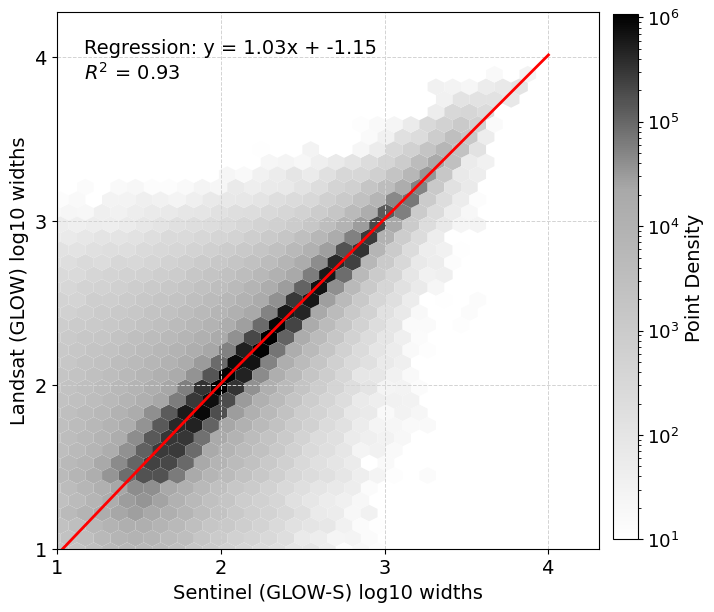

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import numpy as np
from scipy.stats import linregress

# Example for demonstration purposes (replace with actual data)
x = final_large_data_warm_over60_inCOMID_land['width_x']
y = final_large_data_warm_over60_inCOMID_land['width_y']

# Perform linear regression on the original data
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Apply log transformation to data
logx = np.log10(x)
logy = np.log10(y)

# Calculate the regression line in log space for the given range x = 10 to 10001
x_regression_range = np.linspace(10, 10001, 100)
y_regression_range = slope * x_regression_range + intercept

# Create a custom colormap from white to black, emphasizing white for lower densities
cmap_grey_to_black = LinearSegmentedColormap.from_list("grey_to_black", ["white", "lightgray", "darkgray", "black"])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(7, 7))

# Hexbin plot for density with the custom grey-to-black colormap
hb = ax.hexbin(logx, logy, gridsize=60, cmap=cmap_grey_to_black, mincnt=10, edgecolors='none', norm=LogNorm())

# Add color bar with logarithmic scale
cbar_ax = fig.add_axes([0.92, 0.125, 0.035, 0.75])  # Adjusted position [x, y, width, height] to make it shorter
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label('Point Density', fontsize=14)
cb.ax.tick_params(labelsize=13)

# Plot the regression line in the specified range
log_x_regression_range = np.log10(x_regression_range)
log_y_regression_range = np.log10(np.maximum(y_regression_range, 1e-10))  # Prevent log(0)

ax.plot(log_x_regression_range, log_y_regression_range, color='red', linewidth=2, label=f'Regression: y = {slope:.2f}x + {intercept:.2f}')

# Set the title and labels with improved styling (sans-serif, no bold)
# ax.set_title('Logarithmic density plot of \nGLOW and GLOW-S observations (m)', fontsize=16, fontname='sans-serif')
ax.set_xlabel('Sentinel (GLOW-S) log10 widths', fontsize=14, fontname='sans-serif')
ax.set_ylabel('Landsat (GLOW) log10 widths', fontsize=14, fontname='sans-serif')

# Set equal scaling
ax.set_aspect('equal', adjustable='box')

# Configure major and minor grid lines with improved styling
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='lightgray')

# Set major and minor locators with clearer intervals
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# Set limits for the axes
ax.set_xlim(left=1)
ax.set_ylim(bottom=1)

# Customize the appearance of minor grid lines with more subtle styling
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='darkgray')

# Slight adjustments to tick parameters for a cleaner look
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Add the regression equation as text in the top left corner of the plot
ax.text(0.05, 0.95, f'Regression: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}',
        transform=ax.transAxes, fontsize=14, color='black',  verticalalignment='top', horizontalalignment='left')

# Display the plot
plt.show()


In [91]:
final_large_data_warm_over60_inCOMID_land['absdifference'] = (final_large_data_warm_over60_inCOMID_land['width_x'] - final_large_data_warm_over60_inCOMID_land['width_y']).abs()


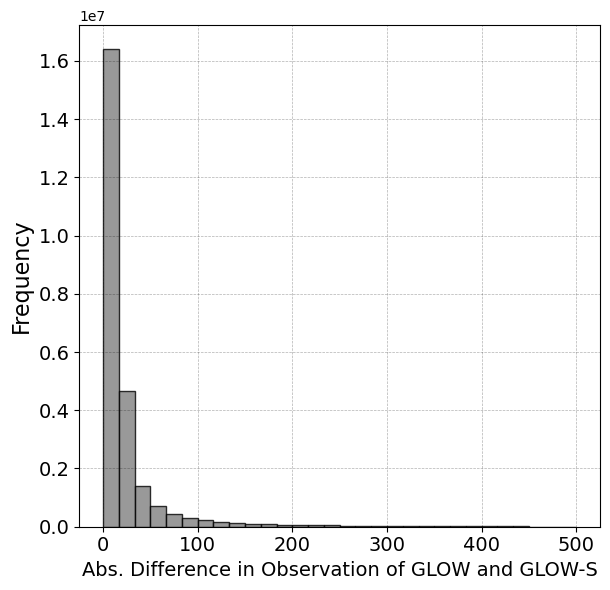

In [92]:
# Adjusting text size for the histogram with larger labels
plt.figure(figsize=(6.2, 6))
plt.hist(final_large_data_warm_over60_inCOMID_land['absdifference'], bins=30, range=(0, 500), color='grey', edgecolor='black', alpha=0.8)
plt.xlabel('Abs. Difference in Observation of GLOW and GLOW-S', fontsize=14)
plt.ylabel('Frequency', fontsize=16)  # Set to normal scale
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="black", alpha=0.3)  # Adding grid for aesthetics
plt.tight_layout()
plt.show()


## Now identify direct peak

### First take the rivers which were not affected and get raw data

In [93]:
import pandas as pd

# Load the parquet file
file_path = 'NCDF_out/ERA5nc/2mTemperature.parquet'
data = pd.read_parquet(file_path)

In [94]:
snow_rivers = data[['COMID', 'Min_t2m']][data['Min_t2m'] < 273.15]['COMID']
non_snow_rivers = data[['COMID', 'Min_t2m']][data['Min_t2m'] > 273.15]['COMID']

In [95]:
len(set(non_snow_rivers))

131489

In [96]:
import sys
import pandas as pd
import numpy as np

# Function to calculate variable sizes
def get_variable_sizes():
    sizes = []
    for name, value in globals().items():
        try:
            # Check type and calculate size for common data structures
            if isinstance(value, pd.DataFrame):
                size = value.memory_usage(deep=True).sum() / (1024**3)  # For DataFrames
            elif isinstance(value, pd.Series):
                size = value.memory_usage(deep=True) / (1024**3)  # For Series
            elif isinstance(value, (list, dict, np.ndarray)):
                size = sys.getsizeof(value) / (1024**3)  # For lists, dicts, and arrays
            else:
                continue  # Skip other types
            sizes.append((name, size))
        except Exception as e:
            print(f"Could not calculate size for {name}: {e}")
    # Sort by size in descending order
    return sorted(sizes, key=lambda x: x[1], reverse=True)

# Print variable sizes
for name, size in get_variable_sizes():
    print(f"{name}: {size:.4f} GB")


large_data_region: 378.6307 GB
_20: 378.6307 GB
final_large_data_warm_over60: 374.3965 GB
_70: 374.3965 GB
_65: 273.9487 GB
_34: 224.3272 GB
_41: 164.5277 GB
final_large_data_warm_COLDONLY_over60: 164.5113 GB
final_large_data_warm_over60_inCOMID: 112.9605 GB
_76: 112.9605 GB
never_snow_regons_merged: 105.2684 GB
_38: 105.2684 GB
_44: 105.2684 GB
binary_temperature_data: 58.8751 GB
_31: 58.8751 GB
final_large_data_warm_over60_inCOMID_land: 16.2110 GB
_83: 16.2110 GB
points_within_coastline: 10.9148 GB
points_on_land: 9.9793 GB
points_gdf: 7.8908 GB
points_df: 7.7423 GB
points_outside_lakes: 7.2151 GB
large_chunk_warmcheck: 3.9520 GB
data: 3.9199 GB
large_data_chunk: 2.9905 GB
temperature_data: 2.8399 GB
points_within_lakes: 1.5583 GB
temperature_chunk: 1.1724 GB
MERIT_df: 0.6041 GB
filtered_data: 0.6033 GB
x: 0.1877 GB
y: 0.1877 GB
logx: 0.1877 GB
logy: 0.1877 GB
gdf_era5: 0.0491 GB
gdf_era5_head: 0.0465 GB
coastline_gdf: 0.0272 GB
df: 0.0249 GB
x_widths: 0.0140 GB
y_widths: 0.0140 GB
l

In [97]:
# import pandas as pd
# from tqdm import tqdm

# # Define base path and file names
# base_path = 'ClimateRegionDivision/HUC_Parquet/'
# file_names = [f"{i}_large.parquet" for i in range(1, 9)]

# # Initialize an empty list to store DataFrames
# huc_dfs = []

# # Loop through the file names and load each DataFrame
# for file_name in tqdm(file_names, desc="Loading files"):
#     df = pd.read_parquet(base_path + file_name)
#     df['COMID'] = pd.to_numeric(df['COMID'], errors='coerce').astype('Int64')
#     df_nosnow = df[df['COMID'].isin(set(non_snow_rivers))]
#     huc_dfs.append(df_nosnow)

# # Concatenate all DataFrames into one
# large_data_region_nosnow = pd.concat(huc_dfs, ignore_index=True)

#### Got large_data_region_nosnow for the snow covered area, with snow covered days removed ⍟⍟⍟

In [98]:
def find_peak_months(df):
    peak_months = []
        
    # Extract year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # Group by year and month, averaging widths for each month
    monthly_data = df.groupby(['year', 'month'])['width'].mean().reset_index()
    
    # Check if at least 8 months of data are present per year
    valid_years = monthly_data.groupby('year').filter(lambda x: len(x) >= 8)

    if valid_years.shape[0] == 0: return "never 8 months"
    if valid_years.shape[0] == 1: return "just 1 year"
    
    # Find the peak month for each year
    for year, group in valid_years.groupby('year'):
        peak_month = group.loc[group['width'].idxmax()]['month']
        peak_months.append((year, peak_month))

    return peak_months

from collections import Counter

def filter_distant_months(most_common_months, threshold=1):
    """
    Removes months that are outside the ±threshold range from the most common month.
    """
    top_month, _ = most_common_months[0]
    filtered_months = []

    # Keep months that are within the threshold proximity of the top month
    for month, count in most_common_months:
        if abs(top_month - month) <= threshold or abs((top_month + 12) - month) <= threshold:
            filtered_months.append((month, count))
    
    return filtered_months
from collections import Counter

def determine_peak_month_with_strict_removal(peak_months, proximity_threshold=1):

    if peak_months == "never 8 months": return  "never 8 months"
    
    # Step 1: Count the frequency of each month
    month_counts = Counter([month for year, month in peak_months])
    
    # Step 2: Sort by frequency
    most_common_months = month_counts.most_common()
    
    # Step 3: Identify the most common (peak) month
    if len(most_common_months) > 1:
        peak_month = most_common_months[0][0]  # The top peak month
        
        # Step 4: Ensure all months are within ±1 month of the peak month
        for month, count in most_common_months:
            if abs(peak_month - month) > proximity_threshold and abs((peak_month + 12) - month) > proximity_threshold:
                return "No clear peak"
    else:
        peak_month = most_common_months[0][0]

    if peak_months == "just 1 year": return "just 1 year " + str(peak_month)
    
    return peak_month


In [99]:
large_data_region_nosnow = never_snow_regons_merged

In [100]:
from tqdm import tqdm
peak_months_list = []

for comid_id, comid_data in tqdm(large_data_region_nosnow.groupby('COMID')):
    peak_months = find_peak_months(comid_data)  # Function assumes list input
    peak_month_result = determine_peak_month_with_strict_removal(peak_months)
    peak_months_list.append((comid_id, peak_month_result))

result_df = pd.DataFrame(peak_months_list, columns=['COMID', 'Direct Peak Month'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131489/131489 [07:56<00:00, 275.83it/s]


In [101]:
result_df

COMID Direct Peak Month
0       11000054     No clear peak
1       11000302               2.0
2       11000308     No clear peak
3       11000309     No clear peak
4       11000766     No clear peak
...          ...               ...
131484  78027819               2.0
131485  78027826     No clear peak
131486  78027828               2.0
131487  78027844     No clear peak
131488  78027927     No clear peak

[131489 rows x 2 columns]

### Now take rivers which were affected then analyse the data

In [102]:
file_path = 'ClimateRegionDivision/HUC_Parquet/coldRegion_large_T273check_over60.parquet'
allRegion_large_T273check_over60 = pd.read_parquet(file_path)

In [103]:
allRegion_large_T273check_over60.shape

(841155406, 10)

In [104]:
from tqdm import tqdm
peak_months_list = []

for comid_id, comid_data in tqdm(allRegion_large_T273check_over60.groupby('COMID')):
    peak_months = find_peak_months(comid_data)  # Function assumes list input
    peak_month_result = determine_peak_month_with_strict_removal(peak_months)
    peak_months_list.append((comid_id, peak_month_result))

result_affected_df = pd.DataFrame(peak_months_list, columns=['COMID', 'Direct Peak Month'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344757/344757 [15:53<00:00, 361.42it/s]


In [105]:
result_affected_df

COMID Direct Peak Month
0       12084791     No clear peak
1       12084794     No clear peak
2       12084796     No clear peak
3       12084797     No clear peak
4       12084799     No clear peak
...          ...               ...
344752  86007242    never 8 months
344753  86007254    never 8 months
344754  86007258    never 8 months
344755  86007267    never 8 months
344756  86007272    never 8 months

[344757 rows x 2 columns]

In [106]:
# Merge info

In [107]:
result_affected_df['T<273'] = 1
result_df['T<273'] = 0
result_affected_unaffected_df = pd.concat([result_affected_df, result_df], ignore_index=True)


In [108]:
# result_affected_unaffected_df = result_affected_df

In [109]:
output_path = 'NCDF_out/direct_peak newresult.csv'
result_affected_unaffected_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to NCDF_out/direct_peak newresult.csv


In [110]:
result_affected_unaffected_df

COMID Direct Peak Month  T<273
0       12084791     No clear peak      1
1       12084794     No clear peak      1
2       12084796     No clear peak      1
3       12084797     No clear peak      1
4       12084799     No clear peak      1
...          ...               ...    ...
476241  78027819               2.0      0
476242  78027826     No clear peak      0
476243  78027828               2.0      0
476244  78027844     No clear peak      0
476245  78027927     No clear peak      0

[476246 rows x 3 columns]

## Final Zenodo Dataset for export

In [111]:
large_data_region_nosnow['date'] = pd.to_datetime(large_data_region_nosnow['date']).dt.date
allRegion_large_T273check_over60['date'] = pd.to_datetime(allRegion_large_T273check_over60['date']).dt.date


In [112]:
large_data_region_nosnow['days2000'] = large_data_region_nosnow['date']
allRegion_large_T273check_over60['days2000'] = allRegion_large_T273check_over60['date']


In [113]:
warm_area = large_data_region_nosnow[(large_data_region_nosnow['COMID'] >= 10000000) & (large_data_region_nosnow['COMID'] < 20000000)]
warm_area

riverID        date       width        lat        lon  \
0          R11000054XS0000001  2017-04-06  284.632214  29.653813  32.352854   
1          R11000054XS0000003  2017-04-06   94.828588  29.656727  32.352440   
2          R11000054XS0000001  2017-05-06  316.912003  29.653813  32.352854   
3          R11000054XS0000002  2017-05-06  327.036912  29.655221  32.352500   
4          R11000054XS0000003  2017-05-06  132.685949  29.656727  32.352440   
...                       ...         ...         ...        ...        ...   
161967460  R18012919XS1286631  2022-12-31   16.698084 -25.095907  46.435000   
161967461  R18012919XS1286633  2022-12-31   78.700755 -25.093662  46.433662   
161967462  R18012919XS1286634  2022-12-31   73.082123 -25.092268  46.433102   
161967463  R18012919XS1286635  2022-12-31   27.673683 -25.091092  46.431925   
161967464  R18012919XS1286638  2022-12-31   60.832657 -25.089717  46.428333   

           sceneID_unique     COMID  month    date_YMD  hot_enough    days2000  
0                   99058  11000054      4  2017-04-06         1.0  2017-04-06  
1                   99058  11000054      4  2017-04-06         1.0  2017-04-06  
2                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
3                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
4                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
...                   ...       ...    ...         ...         ...         ...  
161967460           21094  18012919     12  2022-12-31         1.0  2022-12-31  
161967461           21094  18012919     12  2022-12-31         1.0  2022-12-31  
161967462           21094  18012919     12  2022-12-31         1.0  2022-12-31  
161967463           21094  18012919     12  2022-12-31         1.0  2022-12-31  
161967464           21094  18012919     12  2022-12-31         1.0  2022-12-31  

[161967465 rows x 11 columns]

In [114]:
# warm_area['days2000'] = pd.to_datetime(warm_area['date']).dt.date
warm_area = warm_area[['riverID', 'days2000', 'width']].copy()

In [115]:
warm_area_grouped = warm_area.groupby(['riverID', 'days2000'], as_index=False).agg({'width': 'mean'})

In [116]:
cold_area = allRegion_large_T273check_over60[(allRegion_large_T273check_over60['COMID'] >= 10000000) & (allRegion_large_T273check_over60['COMID'] < 20000000)]
cold_area

riverID        date       width        lat        lon  \
0       R12084791XS2389944  2019-01-12    8.448136 -28.952676  27.725176   
1       R12084791XS2389945  2019-01-12    1.586848 -28.952500  27.724663   
2       R12084791XS2389944  2019-01-12   10.141748 -28.952676  27.725176   
3       R12084791XS2389945  2019-01-12    1.586848 -28.952500  27.724663   
4       R12084791XS2389910  2019-02-06   21.861701 -28.965000  27.723562   
...                    ...         ...         ...        ...        ...   
982962  R15024763XS6842226  2022-12-17   57.984996  31.177500  -8.081898   
982963  R15024763XS6842225  2022-12-22  188.056137  31.178333  -8.083846   
982964  R15024763XS6842226  2022-12-22   83.552766  31.177500  -8.081898   
982965  R15024763XS6842225  2022-12-27  182.984648  31.178333  -8.083846   
982966  R15024763XS6842226  2022-12-27   93.637978  31.177500  -8.081898   

        sceneID_unique     COMID  month    date_YMD  hot_enough    days2000  
0                95294  12084791      1  2019-01-12         1.0  2019-01-12  
1                95294  12084791      1  2019-01-12         1.0  2019-01-12  
2                95295  12084791      1  2019-01-12         1.0  2019-01-12  
3                95295  12084791      1  2019-01-12         1.0  2019-01-12  
4                95361  12084791      2  2019-02-06         1.0  2019-02-06  
...                ...       ...    ...         ...         ...         ...  
982962           42178  15024763     12  2022-12-17         1.0  2022-12-17  
982963           42191  15024763     12  2022-12-22         1.0  2022-12-22  
982964           42191  15024763     12  2022-12-22         1.0  2022-12-22  
982965           42206  15024763     12  2022-12-27         1.0  2022-12-27  
982966           42206  15024763     12  2022-12-27         1.0  2022-12-27  

[982967 rows x 11 columns]

In [117]:
# cold_area['days2000'] = pd.to_datetime(cold_area['date']).dt.date
cold_area = cold_area[['riverID', 'days2000', 'width']].copy()

In [118]:
cold_area_grouped = cold_area.groupby(['riverID', 'days2000'], as_index=False).agg({'width': 'mean'})

In [119]:
warm_area_grouped

riverID    days2000       width
0          R11000054XS0000001  2017-04-06  284.632214
1          R11000054XS0000001  2017-05-06  316.912003
2          R11000054XS0000001  2017-05-16  319.438305
3          R11000054XS0000001  2017-05-26  335.634413
4          R11000054XS0000001  2017-06-19  345.362659
...                       ...         ...         ...
129180019  R18012919XS1286645  2022-03-06  161.933024
129180020  R18012919XS1286645  2022-03-11  114.105012
129180021  R18012919XS1286645  2022-03-17   91.269410
129180022  R18012919XS1286645  2022-03-26  142.767310
129180023  R18012919XS1286646  2022-03-06    3.991972

[129180024 rows x 3 columns]

In [120]:
cold_area_grouped

riverID    days2000       width
0       R12084791XS2389910  2019-02-06   21.056549
1       R12084791XS2389910  2019-02-11    8.422620
2       R12084791XS2389910  2019-02-26    6.659900
3       R12084791XS2389910  2019-04-17    1.848868
4       R12084791XS2389910  2021-02-15   10.198593
...                    ...         ...         ...
870426  R15024763XS6842300  2018-02-13  158.625177
870427  R15024763XS6842300  2022-03-07   67.238651
870428  R15024763XS6842301  2018-01-24    5.077434
870429  R15024763XS6842301  2020-01-22   11.847345
870430  R15024763XS6842301  2020-08-09   19.533186

[870431 rows x 3 columns]

In [121]:
region_snowfree_data = pd.concat([warm_area_grouped, cold_area_grouped], ignore_index=True)

In [122]:
i = 1



### Save the Zenodo data here

In [123]:
for region in tqdm(range(1, 9)):
    file_name = f"ZenodoOut/Snowfree_daywidth/GLOW-S_region_{region}_daywidth.parquet"
    

    warm_area = large_data_region_nosnow[(large_data_region_nosnow['COMID'] >= 10000000 * region) & (large_data_region_nosnow['COMID'] < 10000000 * (region+1))]
    warm_area = warm_area[['riverID', 'days2000', 'width']].copy()
    warm_area_grouped = warm_area.groupby(['riverID', 'days2000'], as_index=False).agg({'width': 'mean'})
    
    cold_area = allRegion_large_T273check_over60[(allRegion_large_T273check_over60['COMID'] >= 10000000 * region) & (allRegion_large_T273check_over60['COMID'] < 10000000 * (region+1))]
    cold_area = cold_area[['riverID', 'days2000', 'width']].copy()
    cold_area_grouped = cold_area.groupby(['riverID', 'days2000'], as_index=False).agg({'width': 'mean'})

    region_snowfree_data = pd.concat([warm_area_grouped, cold_area_grouped], ignore_index=True)
    region_snowfree_data.columns = ['crossSxnID', 'date', 'width']

    region_snowfree_data.to_parquet(file_name, index=False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [17:05<00:00, 128.22s/it]


## Sinusoidal curve fiting

In [124]:
# large_data_region_nosnow = final_large_data_warm_over60

### Function definition

In [125]:
def filteredComidTo60pcMedian(one_comid):
    one_comid_copy = one_comid.copy()
    min_data_taken_from_high_freq_stn = 0.6

    # Make proper date format
    one_comid_copy['date'] = pd.to_datetime(one_comid_copy['date'])
    base_date = pd.to_datetime('2000-01-01')
    one_comid_copy['days2000'] = (one_comid_copy['date'] - base_date).dt.days
    one_comid_copy.drop('date', axis=1, inplace=True)
    
    # Limit the data by taking 70% data from top n frequent COMID
    river_id_counts = one_comid_copy['riverID'].value_counts()
    cumulative_sum = river_id_counts.cumsum()
    total_sum = river_id_counts.sum()
    threshold = min_data_taken_from_high_freq_stn * total_sum
    filtered_data = one_comid_copy[one_comid_copy['riverID'].isin(river_id_counts.index[0:cumulative_sum[cumulative_sum < threshold].count() + 1])]
    
    filtered_data['width_norm'] = filtered_data['width'] * filtered_data['width'].mean() / filtered_data.groupby('riverID')['width'].transform('mean')
    
    # Limit the data to 2% and 98% quantile width_norm
    quantile_bot = filtered_data['width_norm'].quantile(0.02)
    quantile_top = filtered_data['width_norm'].quantile(0.98)
    filtered_data = filtered_data[(filtered_data['width_norm'] > quantile_bot) & (filtered_data['width_norm'] < quantile_top)]
    
    # Median data computation
    median_days2000 = filtered_data.groupby('days2000')['width_norm'].median()
    return median_days2000

In [126]:
# Standard Error of Means
def calculate_sem_from_residuals(residuals):
    std_dev = np.std(residuals)
    n = len(residuals)
    sem = std_dev / np.sqrt(n)
    return sem

# Root Relative Squared Error (RRSE)
def calculate_RRSE(original_data, projected_data):
    mean_original = np.mean(original_data)
    numerator = np.sum((projected_data - original_data) ** 2)
    denominator = np.sum((mean_original - original_data) ** 2)
    return np.sqrt(numerator / denominator)

def perform_kuipers_test(data1, data2):
    # Perform the Kuipers test for two datasets
    ks_statistic = ks_2samp(data1, data2).statistic
    # A great fit has a low KS statistic, indicating similarity between the two datasets.
    # A bad fit has a high KS statistic, indicating dissimilarity between the two datasets.
    return ks_statistic

# Relative Absolute Error (RAE)
def calculate_RAE(original_data, projected_data):
    mean_original = np.mean(original_data)
    numerator = np.sum(np.abs(projected_data - original_data))
    denominator = np.sum(np.abs(mean_original - original_data))
    return numerator / denominator

# Normalized Root Mean Square Error (NRMSE)
def calculate_NRMSE(original_data, projected_data):
    rmse = np.sqrt(np.mean((projected_data - original_data) ** 2))
    data_range = np.max(original_data) - np.min(original_data)
    nrmse = rmse / data_range
    return nrmse


In [127]:
from scipy.optimize import minimize

# Define the sine function with a custom time period
def sine_curve_one(x, amplitude, intercept, phase):
    time_period = 365.25
    return np.abs(float(amplitude)) * np.sin((2 * np.pi * x / time_period) + (2 * np.pi * phase / time_period)) + intercept

# # Create a cost function for optimization
# def cost_function(parameters, xdata, ydata):
#     amplitude, intercept, phase = parameters
#     predicted_data = sine_curve_one(xdata, amplitude, intercept, phase)
#     error = ydata - predicted_data
#     return np.sum(error ** 2)  # Minimize the sum of squared errors


In [128]:
import numpy as np
import scipy.stats

def calculate_cv_iqr(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    cv = (std_dev / mean) * 100

    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1

    return cv, iqr, len(data)


In [129]:
def process_COMID(thatCOMID, thatCOMID_sampling, COMID_dataCount):
    mean_months = thatCOMID_sampling.groupby('month')['width'].mean()
    unique_months = len(mean_months)
    cv_month, iqr_month, count_month = calculate_cv_iqr(mean_months.values)

    median_days2000 = filteredComidTo60pcMedian(thatCOMID_sampling)
    residuals_flat = median_days2000 - median_days2000.mean()
    COMID_dataCount[thatCOMID] =  len(median_days2000)

    if len(median_days2000) > 60:
        standard_error = calculate_sem_from_residuals(residuals_flat)
        cv = stats.variation(median_days2000.values) * 100

        dates = median_days2000.index
        widths = median_days2000.values
        stddev = np.std(widths)

        x = np.asarray(dates)
        y = np.asarray(widths)

        # Define multiple sets of parameters with different phase guesses
        params0 = Parameters()
        params0.add('amplitude', value=stddev * 5, min=0)
        params0.add('intercept', value=np.median(y) / 2, min=0)
        params0.add('phase', value=0, min=-365.25 * 2, max=365.25 * 3)

        params90 = Parameters()
        params90.add('amplitude', value=stddev * 5, min=0)
        params90.add('intercept', value=np.median(y) / 2, min=0)
        params90.add('phase', value=90, min=-365.25 * 2, max=365.25 * 3)

        params180 = Parameters()
        params180.add('amplitude', value=stddev * 5, min=0)
        params180.add('intercept', value=np.median(y) / 2, min=0)
        params180.add('phase', value=180, min=-365.25 * 2, max=365.25 * 3)

        params270 = Parameters()
        params270.add('amplitude', value=stddev * 5, min=0)
        params270.add('intercept', value=np.median(y) / 2, min=0)
        params270.add('phase', value=270, min=-365.25 * 2, max=365.25 * 3)

        # Create models with different phase guesses
        dmodel0 = Model(sine_curve_one)
        result0 = dmodel0.fit(y, params0, x=x)
        
        dmodel90 = Model(sine_curve_one)
        result90 = dmodel90.fit(y, params90, x=x)
        
        dmodel180 = Model(sine_curve_one)
        result180 = dmodel180.fit(y, params180, x=x)

        dmodel270 = Model(sine_curve_one)
        result270 = dmodel270.fit(y, params270, x=x)
        
        # Calculate the sum of squared residuals for each fit
        ssr0 = np.sum(result0.residual ** 2)
        ssr90 = np.sum(result90.residual ** 2)
        ssr180 = np.sum(result180.residual ** 2)
        ssr270 = np.sum(result270.residual ** 2)

        # Choose the best fit based on the least sum of squares (LSS)
        best_result = min((result0, result90, result180, result270), key=lambda result: np.sum(result.residual ** 2))

        amp = best_result.params['amplitude'].value
        inc = best_result.params['intercept'].value
        pek = best_result.params['phase'].value

        params = (amp, inc, pek)
        sine_curve_one_gen_data = sine_curve_one(dates, *params)
        residuals_curve = median_days2000.values - sine_curve_one_gen_data
        standard_error_sine = calculate_sem_from_residuals(residuals_curve)

        slope, intercept, r_value, p_value, std_err = stats.linregress(median_days2000.index, median_days2000.values)

        iqr = np.percentile(widths, 75) - np.percentile(widths, 25)
        median_widths = np.median(widths)

        ks_stat2 = perform_kuipers_test(widths, sine_curve_one_gen_data)
        rrse = calculate_RRSE(widths, sine_curve_one_gen_data)
        rae = calculate_RAE(widths, sine_curve_one_gen_data)
        nrmse = calculate_NRMSE(widths, sine_curve_one_gen_data)

        return [thatCOMID, amp, inc, pek, cv, slope, intercept, r_value ** 2, p_value, standard_error, standard_error_sine, ks_stat2, rae, rrse, nrmse, stddev, iqr, median_widths, cv_month, iqr_month, count_month]
    else:
        return []



def worker(args):
    return process_COMID(*args)



In [130]:
import os
import glob
import pandas as pd
import numpy as np
import pyarrow as pa
from tqdm import tqdm
from dbfread import DBF
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import ks_2samp
from matplotlib.dates import MonthLocator, DateFormatter
import warnings
import multiprocessing
from lmfit import Model
# import lmfit
from lmfit import minimize,Parameters,Parameter,report_fit

print('loaded')


loaded


### Sinusoidal peak hot region

In [131]:
large_data_region_nosnow

riverID        date       width        lat         lon  \
0          R11000054XS0000001  2017-04-06  284.632214  29.653813   32.352854   
1          R11000054XS0000003  2017-04-06   94.828588  29.656727   32.352440   
2          R11000054XS0000001  2017-05-06  316.912003  29.653813   32.352854   
3          R11000054XS0000002  2017-05-06  327.036912  29.655221   32.352500   
4          R11000054XS0000003  2017-05-06  132.685949  29.656727   32.352440   
...                       ...         ...         ...        ...         ...   
559559594  R78027927XS0147569  2022-12-06   22.856135  42.185966 -124.134868   
559559595  R78027927XS0147569  2022-12-13   82.885030  42.185966 -124.134868   
559559596  R78027927XS0147570  2022-12-13   34.744213  42.186366 -124.134467   
559559597  R78027927XS0147569  2022-12-16   58.222716  42.185966 -124.134868   
559559598  R78027927XS0147570  2022-12-16    6.303858  42.186366 -124.134467   

           sceneID_unique     COMID  month    date_YMD  hot_enough    days2000  
0                   99058  11000054      4  2017-04-06         1.0  2017-04-06  
1                   99058  11000054      4  2017-04-06         1.0  2017-04-06  
2                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
3                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
4                   99061  11000054      5  2017-05-06         1.0  2017-05-06  
...                   ...       ...    ...         ...         ...         ...  
559559594           33477  78027927     12  2022-12-06         1.0  2022-12-06  
559559595           33484  78027927     12  2022-12-13         1.0  2022-12-13  
559559596           33484  78027927     12  2022-12-13         1.0  2022-12-13  
559559597           33498  78027927     12  2022-12-16         1.0  2022-12-16  
559559598           33498  78027927     12  2022-12-16         1.0  2022-12-16  

[559559599 rows x 11 columns]

In [132]:
large_data_region_nosnow.shape

(559559599, 11)

In [133]:
import requests

def send_ntfy_notification(title, message, priority="urgent", tags="bell,fire"):
    url = "https://ntfy.sh/river_width_res"
    headers = {
        "Title": title,
        "Priority": priority,
        "Tags": tags
    }
    response = requests.post(url, data=message, headers=headers)
    return response

# Example usage after a cell completes
send_ntfy_notification(
    title="Notebook Alert: Cell Execution Complete",
    message="Your cell has successfully completed execution!",
    priority="urgent",
    tags="bell,fire"
)

<Response [200]>

In [134]:
# Main code
warnings.filterwarnings("ignore")
index = 0


COMID_dataCount = {}
COMID_dataCollection = [['COMID', 'amplitude', 'intercept', 'phase', 'CV_flat', 'slope', 'intercept_c', 'R2', 'p_value', 'SE_flat', 'SE_sine', 'ks_stat', 'rae', 'rrse', 'nrmse', 'stddev', 'IQR', 'Med_width', 'CV_month', 'IQR_month', 'Count_month']]

jobs = [(thatCOMID, thatCOMID_sampling, COMID_dataCount) for thatCOMID, thatCOMID_sampling in large_data_region_nosnow.groupby('COMID')]
num_processes = 8

with multiprocessing.Pool(num_processes) as pool:results = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131489/131489 [10:58<00:00, 199.57it/s]


In [135]:
for result in results:
    if result:
        COMID_dataCollection.append(result)

region_river_60pc_original = pd.DataFrame(COMID_dataCollection[1:], columns=COMID_dataCollection[0])

### Sinusoidal peak removed snow data

In [136]:
allRegion_large_T273check_over60

riverID        date       width        lat         lon  \
0          R12084791XS2389944  2019-01-12    8.448136 -28.952676   27.725176   
1          R12084791XS2389945  2019-01-12    1.586848 -28.952500   27.724663   
2          R12084791XS2389944  2019-01-12   10.141748 -28.952676   27.725176   
3          R12084791XS2389945  2019-01-12    1.586848 -28.952500   27.724663   
4          R12084791XS2389910  2019-02-06   21.861701 -28.965000   27.723562   
...                       ...         ...         ...        ...         ...   
841155401  R86007272XS4702789  2022-08-30  174.460430  74.455969 -113.395698   
841155402  R86007272XS4702791  2022-08-30  203.595492  74.456667 -113.388139   
841155403  R86007272XS4702792  2022-08-30  192.266348  74.456667 -113.383362   
841155404  R86007272XS4702795  2022-08-30  116.841376  74.457500 -113.371413   
841155405  R86007272XS4702811  2022-08-30  196.517060  74.452500 -113.314054   

           sceneID_unique     COMID  month    date_YMD  hot_enough    days2000  
0                   95294  12084791      1  2019-01-12         1.0  2019-01-12  
1                   95294  12084791      1  2019-01-12         1.0  2019-01-12  
2                   95295  12084791      1  2019-01-12         1.0  2019-01-12  
3                   95295  12084791      1  2019-01-12         1.0  2019-01-12  
4                   95361  12084791      2  2019-02-06         1.0  2019-02-06  
...                   ...       ...    ...         ...         ...         ...  
841155401           11485  86007272      8  2022-08-30         1.0  2022-08-30  
841155402           11485  86007272      8  2022-08-30         1.0  2022-08-30  
841155403           11485  86007272      8  2022-08-30         1.0  2022-08-30  
841155404           11485  86007272      8  2022-08-30         1.0  2022-08-30  
841155405           11485  86007272      8  2022-08-30         1.0  2022-08-30  

[841155406 rows x 11 columns]

In [137]:
allRegion_large_T273check_over60.shape

(841155406, 11)

In [138]:
# Main code
warnings.filterwarnings("ignore")
index = 0


COMID_dataCount = {}
COMID_dataCollection = [['COMID', 'amplitude', 'intercept', 'phase', 'CV_flat', 'slope', 'intercept_c', 'R2', 'p_value', 'SE_flat', 'SE_sine', 'ks_stat', 'rae', 'rrse', 'nrmse', 'stddev', 'IQR', 'Med_width', 'CV_month', 'IQR_month', 'Count_month']]

jobs = [(thatCOMID, thatCOMID_sampling, COMID_dataCount) for thatCOMID, thatCOMID_sampling in allRegion_large_T273check_over60.groupby('COMID')]
num_processes = 8

with multiprocessing.Pool(num_processes) as pool:results_nosnow = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344757/344757 [18:01<00:00, 318.75it/s]


In [139]:
for result in results_nosnow:
    if result:
        COMID_dataCollection.append(result)

region_river_60pc_nosnow = pd.DataFrame(COMID_dataCollection[1:], columns=COMID_dataCollection[0])

In [140]:
region_river_60pc_nosnow['T<273'] = 1 #350k
region_river_60pc_original['T<273'] = 0 #150k
result_affected_unaffected_sine_df = pd.concat([region_river_60pc_nosnow, region_river_60pc_original], ignore_index=True)

In [141]:
output_path = 'NCDF_out/sine_peak newresult.csv'
result_affected_unaffected_sine_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to NCDF_out/sine_peak newresult.csv


# Seasonalty Analysis

## IQR analysis

In [142]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

# Define the function that processes each COMID
def process_comid(thatCOMID, thatCOMID_sampling):
    median_days2000 = filteredComidTo60pcMedian(thatCOMID_sampling)
    dates = median_days2000.index
    widths = median_days2000.values

    if median_days2000.shape[0] == 0:
        return [thatCOMID, -1, -1, thatCOMID_sampling.shape[0], len(thatCOMID_sampling['date'].unique())]

    # Calculate IQR and median
    iqr = np.percentile(widths, 75) - np.percentile(widths, 25)
    median_widths = np.median(widths)
    count = thatCOMID_sampling.shape[0]
    days = len(thatCOMID_sampling['date'].unique())

    # Return the results for this COMID
    return [thatCOMID, iqr, median_widths, count, days]

# Define a helper function to pass to multiprocessing.Pool
def worker(job):
    return process_comid(*job)


### IQR hot region

In [143]:
# Create the job list (pairs of thatCOMID and thatCOMID_sampling)
jobs = [(thatCOMID, thatCOMID_sampling) for thatCOMID, thatCOMID_sampling in large_data_region_nosnow.groupby('COMID')]

# Use multiprocessing with 6 cores and tqdm for progress
num_cores = 8
with multiprocessing.Pool(num_cores) as pool:
    results = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results, columns=['COMID', 'IQR', 'Median_Width', 'Count', 'Days'])

# Add a new column for IQRc
results_df['IQRc'] = results_df['IQR'] / results_df['Median_Width']

# Ensure Days and Count columns are integers
results_df['Days'] = results_df['Days'].astype(int)
results_df['Count'] = results_df['Count'].astype(int)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131489/131489 [08:41<00:00, 251.92it/s]


In [144]:
region_river_original_IQR = results_df #150k

### IQR removed snow data

In [145]:
# Create the job list (pairs of thatCOMID and thatCOMID_sampling)
jobs = [(thatCOMID, thatCOMID_sampling) for thatCOMID, thatCOMID_sampling in allRegion_large_T273check_over60.groupby('COMID')]

# Use multiprocessing with 6 cores and tqdm for progress
num_cores = 8
with multiprocessing.Pool(num_cores) as pool:
    results = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results, columns=['COMID', 'IQR', 'Median_Width', 'Count', 'Days'])

# Add a new column for IQRc
results_df['IQRc'] = results_df['IQR'] / results_df['Median_Width']

# Ensure Days and Count columns are integers
results_df['Days'] = results_df['Days'].astype(int)
results_df['Count'] = results_df['Count'].astype(int)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344757/344757 [13:01<00:00, 441.10it/s]


In [146]:
region_river_nosnow_IQR = results_df #350k

In [147]:
region_river_nosnow_IQR['T<273'] = 1 #350k
region_river_original_IQR['T<273'] = 0 #150k
result_affected_unaffected_IQR_df = pd.concat([region_river_nosnow_IQR, region_river_original_IQR], ignore_index=True)

In [148]:
output_path = 'NCDF_out/IQR newresult.csv'
result_affected_unaffected_IQR_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to NCDF_out/IQR newresult.csv


## Kruskal Seasonality Test

### Kruskal hot region

In [149]:
from scipy import stats
from tqdm import tqdm
import warnings
import numpy as np
from scipy.stats import kruskal
warnings.filterwarnings('ignore')

all_params = {}

min_data_taken_from_high_freq_stn = 0.6
large_data_region_nosnow['date'] = pd.to_datetime(large_data_region_nosnow['date'])
base_date = pd.to_datetime('2000-01-01')
large_data_region_nosnow['days2000'] = (large_data_region_nosnow['date'] - base_date).dt.days
large_data_region_nosnow['days2000'] = pd.to_datetime(large_data_region_nosnow['date'].dt.strftime('%Y-%m-%d'))
latlon_comid = large_data_region_nosnow.groupby('COMID').first().reset_index()


min_days_data = 20
min_data_taken_from_high_freq_stn = 0.6 #60% of the data is held

df_summary = pd.DataFrame(columns=['COMID', 'seasonality'])

count = 0
count_lake = 0
for thatCOMID, thatCOMID_sampling in tqdm(large_data_region_nosnow.groupby(['COMID'])):
    count += 1
    
    river_id_counts = thatCOMID_sampling['riverID'].value_counts()
    cumulative_sum = river_id_counts.cumsum()
    total_sum = river_id_counts.sum()
    threshold = min_data_taken_from_high_freq_stn * total_sum
    filtered_data = thatCOMID_sampling[thatCOMID_sampling['riverID'].isin(river_id_counts.index[0:cumulative_sum[cumulative_sum < threshold].count() + 1])]
    
    filtered_data['width_normalized'] = filtered_data['width'] / filtered_data.groupby('riverID')['width'].transform('mean')
    median_days2000 = filtered_data.groupby('days2000')['width_normalized'].median()
    # median_days2000 = thatCOMID_sampling.groupby('days2000')['width'].median()
    
    median = median_days2000.median()
    iqr = median_days2000.quantile(0.75) - median_days2000.quantile(0.25)
    
    threshold = 1.5 * iqr
    
    lower_bound = median - threshold
    upper_bound = median + threshold
    
    median_days2000 = median_days2000[(median_days2000 >= lower_bound) & (median_days2000 <= upper_bound)]
    
    if median_days2000.shape[0] < min_days_data:
        df_summary.loc[len(df_summary)] = [thatCOMID[0], 'low data']

        # all_params.append(("low data", thatCOMID, median_days2000.shape[0]))
        # all_params[thatCOMID] = ("low data", median_days2000.shape[0])
        continue
    
    dates = median_days2000.index
    widths = median_days2000.values

    data = {
        'datetime': dates,
        'data': widths
    }
    
    df = pd.DataFrame(data)
    df['month'] = df['datetime'].dt.month

    try:
        groups = [group['data'].values for name, group in df.groupby('month')]
        stat, p_value = kruskal(*groups)
        
        alpha = 0.05
        if p_value < alpha:
            df_summary.loc[len(df_summary)] = [thatCOMID[0], 'seasonal']
        else:
            df_summary.loc[len(df_summary)] = [thatCOMID[0], 'non seasonal']

    except ValueError as e:
        count_lake += 1
        df_summary.loc[len(df_summary)] = [thatCOMID[0], 'possible lake']

print(count)
print('Number of lakes are ', count_lake)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131489/131489 [17:33<00:00, 124.77it/s]


131489
Number of lakes are  86


In [150]:
region_river_original_kruskal = df_summary

### Kruskal removed snow data

In [151]:
from scipy import stats
from tqdm import tqdm
import warnings
import numpy as np
from scipy.stats import kruskal
warnings.filterwarnings('ignore')

all_params = {}

min_data_taken_from_high_freq_stn = 0.6
allRegion_large_T273check_over60['date'] = pd.to_datetime(allRegion_large_T273check_over60['date'])
base_date = pd.to_datetime('2000-01-01')
allRegion_large_T273check_over60['days2000'] = (allRegion_large_T273check_over60['date'] - base_date).dt.days
allRegion_large_T273check_over60['days2000'] = pd.to_datetime(allRegion_large_T273check_over60['date'].dt.strftime('%Y-%m-%d'))
latlon_comid = allRegion_large_T273check_over60.groupby('COMID').first().reset_index()


min_days_data = 20
min_data_taken_from_high_freq_stn = 0.6 #60% of the data is held

df_summary = pd.DataFrame(columns=['COMID', 'seasonality'])

count = 0
count_lake = 0
for thatCOMID, thatCOMID_sampling in tqdm(allRegion_large_T273check_over60.groupby(['COMID'])):
    count += 1
    
    river_id_counts = thatCOMID_sampling['riverID'].value_counts()
    cumulative_sum = river_id_counts.cumsum()
    total_sum = river_id_counts.sum()
    threshold = min_data_taken_from_high_freq_stn * total_sum
    filtered_data = thatCOMID_sampling[thatCOMID_sampling['riverID'].isin(river_id_counts.index[0:cumulative_sum[cumulative_sum < threshold].count() + 1])]
    
    filtered_data['width_normalized'] = filtered_data['width'] / filtered_data.groupby('riverID')['width'].transform('mean')
    median_days2000 = filtered_data.groupby('days2000')['width_normalized'].median()
    # median_days2000 = thatCOMID_sampling.groupby('days2000')['width'].median()
    
    median = median_days2000.median()
    iqr = median_days2000.quantile(0.75) - median_days2000.quantile(0.25)
    
    threshold = 1.5 * iqr
    
    lower_bound = median - threshold
    upper_bound = median + threshold
    
    median_days2000 = median_days2000[(median_days2000 >= lower_bound) & (median_days2000 <= upper_bound)]
    
    if median_days2000.shape[0] < min_days_data:
        df_summary.loc[len(df_summary)] = [thatCOMID[0], 'low data']

        # all_params.append(("low data", thatCOMID, median_days2000.shape[0]))
        # all_params[thatCOMID] = ("low data", median_days2000.shape[0])
        continue
    
    dates = median_days2000.index
    widths = median_days2000.values

    data = {
        'datetime': dates,
        'data': widths
    }
    
    df = pd.DataFrame(data)
    df['month'] = df['datetime'].dt.month

    try:
        groups = [group['data'].values for name, group in df.groupby('month')]
        stat, p_value = kruskal(*groups)
        
        alpha = 0.05
        if p_value < alpha:
            df_summary.loc[len(df_summary)] = [thatCOMID[0], 'seasonal']
        else:
            df_summary.loc[len(df_summary)] = [thatCOMID[0], 'non seasonal']

    except ValueError as e:
        count_lake += 1
        df_summary.loc[len(df_summary)] = [thatCOMID[0], 'possible lake']

print(count)
print('Number of lakes are ', count_lake)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344757/344757 [53:42<00:00, 107.00it/s]


344757
Number of lakes are  122


In [152]:
region_river_nosnow_kruskal = df_summary

In [153]:
region_river_nosnow_kruskal['T<273'] = 1 #350k
region_river_original_kruskal['T<273'] = 0 #150k
result_affected_unaffected_kruskal_df = pd.concat([region_river_nosnow_kruskal, region_river_original_kruskal], ignore_index=True)

In [154]:
output_path = 'NCDF_out/Kruskal newresult.csv'
result_affected_unaffected_kruskal_df.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to NCDF_out/Kruskal newresult.csv


## Merge Results: Peaks, Sinusoidal Fit, Seasonality, IQR

In [155]:
# Information about freeflowing rivers
file_path = "ClimateRegionDivision/AllFiles/FFR_river_network/FFR_river_network.csv"
df_FFR_river = pd.read_csv(file_path)

file_path = "/N/lustre/project/proj-212/Aaditya/Sediment_digitized_file_join/Data/link_grades_riveratlas.csv"
df_COMID_HydroID = pd.read_csv(file_path)

In [156]:
output_path = 'NCDF_out/sine_peak newresult.csv'
result_affected_unaffected_sine_df = pd.read_csv(output_path)

In [157]:
output_path = 'NCDF_out/IQR newresult.csv'
result_affected_unaffected_IQR_df = pd.read_csv(output_path)

In [158]:
output_path = 'NCDF_out/Kruskal newresult.csv'
result_affected_unaffected_kruskal_df = pd.read_csv(output_path)

In [159]:
output_path = 'NCDF_out/direct_peak newresult.csv'
result_affected_unaffected_df = pd.read_csv(output_path)

In [160]:
df_FFR_river['REACH_ID'] = df_FFR_river['REACH_ID'].astype(int)
result_affected_unaffected_sine_df['COMID'] = result_affected_unaffected_sine_df['COMID'].astype(int)

result_affected_unaffected_sine_df_wHydroID = pd.merge(result_affected_unaffected_sine_df, df_COMID_HydroID, left_on='COMID', right_on='COMID', how='inner')
result_df_FFR_river = pd.merge(result_affected_unaffected_sine_df_wHydroID, df_FFR_river, left_on='REACH_ID', right_on='REACH_ID', how='inner')
result_df_FFR_river['freeflow_check'] = (result_df_FFR_river['CSI'] > 95).astype(int)
result_df_FFR_river['fit_check'] = (result_df_FFR_river['nrmse'] <= 0.175).astype(int)

In [161]:
result_df_FFR_river['phase_adj'] = result_df_FFR_river['phase'] % 365.25
result_df_FFR_river['phase_fadj'] = ((365.25 - result_df_FFR_river['phase_adj']) + 365.25/4) % 365.25

def day_to_month_number_and_name(day):
    days_in_month = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if day < 0 or day > 365.25:
        return None, None  # Invalid input
    for i in range(12):
        if day <= days_in_month[i]:
            return i + 1, month_names[i]  # Month number and name
        day -= days_in_month[i]

# Apply the function to calculate the two new columns
result_df_FFR_river[['int_month', 'str_month']] = result_df_FFR_river['phase_fadj'].apply(
    lambda day: pd.Series(day_to_month_number_and_name(day))
)


In [162]:
merged_seasonality_df = result_df_FFR_river[['COMID', 'T<273', 'nrmse', 'fit_check', 'freeflow_check', 'int_month']].merge(
    result_affected_unaffected_IQR_df[['COMID', 'Count', 'Days', 'IQRc']], 
    on='COMID', 
    how='inner'
).merge(
    result_affected_unaffected_kruskal_df[['COMID', 'seasonality']], 
    on='COMID', 
    how='inner'
).merge(
    result_affected_unaffected_df[['COMID', 'Direct Peak Month']], 
    on='COMID', 
    how='inner'
)


In [163]:
merged_seasonality_df

COMID  T<273     nrmse  fit_check  freeflow_check  int_month  \
0       12084791      1  0.206626          0               0          3   
1       12084794      1  0.173743          1               0          3   
2       12084796      1  0.219266          0               0          3   
3       12084797      1  0.210017          0               0          3   
4       12084799      1  0.214120          0               0          3   
...          ...    ...       ...        ...             ...        ...   
358985  78027819      0  0.139525          1               1          3   
358986  78027826      0  0.135478          1               1          3   
358987  78027828      0  0.150404          1               1          3   
358988  78027844      0  0.157703          1               1         12   
358989  78027927      0  0.194080          0               1          3   

        Count  Days      IQRc seasonality Direct Peak Month  
0        3106   127  0.694283    seasonal     No clear peak  
1        5324   198  0.426935    seasonal     No clear peak  
2        3858   138  0.589958    seasonal     No clear peak  
3        1017   117  0.712337    seasonal     No clear peak  
4        4467   128  0.698593    seasonal     No clear peak  
...       ...   ...       ...         ...               ...  
358985  25117   298  0.465953    seasonal               2.0  
358986  15561   303  0.474091    seasonal     No clear peak  
358987  19960   298  0.408580    seasonal               2.0  
358988   1418   211  0.456048    seasonal     No clear peak  
358989    653   228  0.811734    seasonal     No clear peak  

[358990 rows x 11 columns]

In [164]:
def classify_seasonality(row):
    if row['IQRc'] < 0.1:
        return "Steady"
    elif row['IQRc'] > 0.1 and row['seasonality'] == "non seasonal":
        return "Non Seasonal"
    elif row['IQRc'] > 0.1 and row['seasonality'] == "seasonal" and row['fit_check'] == 1:
        return "Sine Seasonal"
    elif row['IQRc'] > 0.1 and row['seasonality'] == "seasonal" and row['fit_check'] == 0:
        return "Non-Sine Seasonal"
    return None  # Default case (if no condition is met)

merged_seasonality_df['Seasonality'] = merged_seasonality_df.apply(classify_seasonality, axis=1)

In [165]:
merged_seasonality_df['Seasonality'].value_counts()

Seasonality
Sine Seasonal        128079
Non-Sine Seasonal    100591
Non Seasonal          74149
Steady                56170
Name: count, dtype: int64

## Plot Peaks and Seasonality

In [166]:
import geopandas as gpd
world_subcatchments = gpd.read_file("ClimateRegionDivision/HUC_Parquet/WorldSubcatchments/hybas_world_lev05_v1c.shp")
world_subcatchments = world_subcatchments.drop(columns=['path'])

In [167]:
import geopandas as gpd
import os

base_dir = "/N/lustre/project/proj-212/Dongmei/MERIT_Hydro/"
shapefiles = [f"riv_pfaf_{i}_MERIT_Hydro_v07_Basins_v01.shp" for i in range(1, 9)]
merged_line_gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(os.path.join(base_dir, shp)) for shp in shapefiles], ignore_index=True))


In [168]:
merged_line_gdf['COMID'] = merged_line_gdf['COMID'].astype(int)
combined_raw_seasonality_sin_gdf = merged_line_gdf.merge(merged_seasonality_df, on='COMID', how='inner')


In [169]:
import geopandas as gpd
import pandas as pd
from scipy import stats

# Perform a spatial join to associate points with polygons
joined_gdf = gpd.sjoin(combined_raw_seasonality_sin_gdf, world_subcatchments, how="inner", op="intersects")

# Group by the polygon index and calculate the mode of the sin_season column
mode_data = joined_gdf.groupby('index_right')['Seasonality'].apply(lambda x: stats.mode(x)[0][0])

# Count the number of points falling within each polygon
point_counts = joined_gdf.groupby('index_right').size()

# Add the mode and point count as new columns to the world_subcatchments GeoDataFrame
world_subcatchments['sin_season_mode'] = world_subcatchments.index.map(mode_data)
world_subcatchments['point_count'] = world_subcatchments.index.map(point_counts)

# Handle cases where no points fall within a polygon (NaN values)
world_subcatchments['sin_season_mode'] = world_subcatchments['sin_season_mode'].fillna('No Data')
world_subcatchments['point_count'] = world_subcatchments['point_count'].fillna(0)

# Calculate Area_by_point with a conditional check for point_count 
world_subcatchments['Area_by_point'] = np.where(
    world_subcatchments['point_count'] == 0,  # Condition: point_count is 0
    0,  # Value if condition is true
    world_subcatchments['SUB_AREA'] / world_subcatchments['point_count']  # Value if condition is false
)

world_subcatchments.loc[world_subcatchments['Area_by_point'] >= 1000, 'sin_season_mode'] = 'No Data'

In [170]:
world_subcatchments['sin_season_mode'].value_counts()

sin_season_mode
No Data              1593
Sine Seasonal        1293
Non-Sine Seasonal     821
Non Seasonal          512
Steady                420
Name: count, dtype: int64

In [171]:
world_subcatchments.to_file("NCDF_out/world_subcatchments updated.gpkg", driver="GPKG")

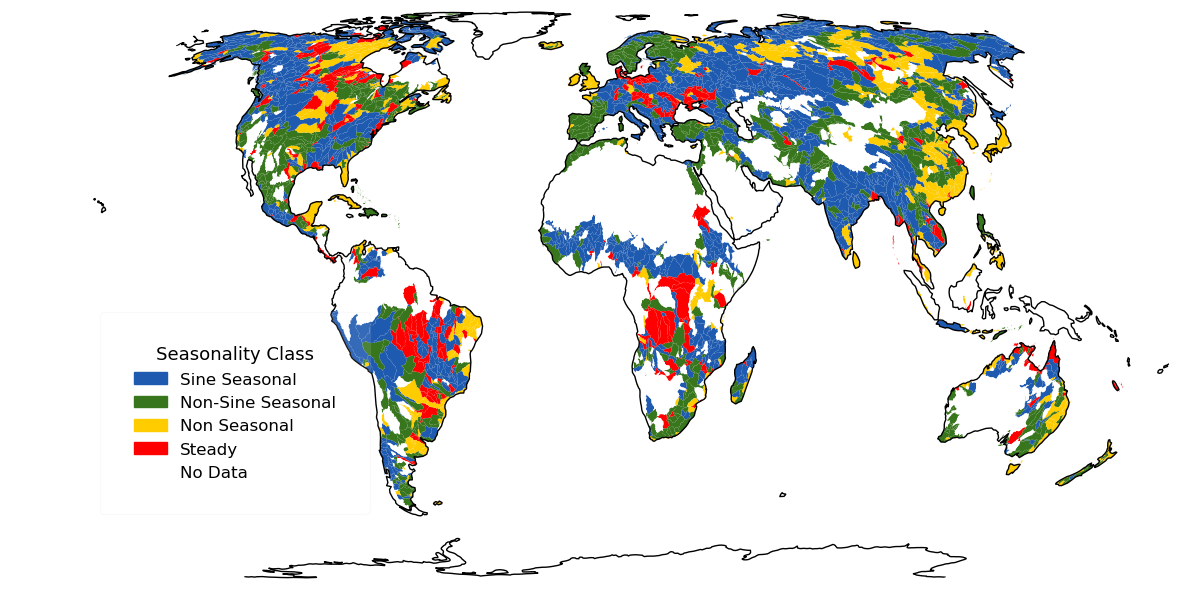

In [172]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import geopandas as gpd

gdf = gpd.read_file('ClimateRegionDivision/HUC_Parquet/TempShapefiles/random1000pt4robinson.gpkg')

# Define a milder color map for the sin_season_mode categories
bold_color_map = {
    'Sine Seasonal': '#1E5AAF',  # Bolder Blue
    'Non-Sine Seasonal': '#38761D',  # Bolder Green
    'Non Seasonal': '#FFCC00',  # Bolder Yellow
    'Steady':'red',
    'No Data': '#FFFFFF'  # Bolder Grey
}

# Assuming 'world_subcatchments' is a GeoDataFrame that includes geometries and 'sin_season_mode'
world_subcatchments['color'] = world_subcatchments['sin_season_mode'].map(bold_color_map)

# Create figure and axis with an "Equal Earth" projection (similar to Peterson)
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.EqualEarth()})

# Plot the world_subcatchments GeoDataFrame colored by sin_season_mode
world_subcatchments.plot(color=world_subcatchments['color'], ax=ax, linewidth=0.5, edgecolor=None, alpha=1, transform=ccrs.PlateCarree())

# Set title and labels with larger font sizes
# ax.set_title('Subbasins by Seasonality Classes', fontsize=24, pad=20)  # Larger title font, added pad for space

# Increase the font size of tick labels (axes labels)
ax.tick_params(labelsize=14)

# Plot the gdf with larger marker size and transparency
gdf.plot(ax=ax, marker='o', color='black', markersize=10, alpha=1, transform=ccrs.PlateCarree())

# Remove the gridlines and labels but keep the overall boundary
ax.set_global()
ax.coastlines()
# ax.set_extent([-180, 220, -65, 85], crs=ccrs.PlateCarree())
# ax.set_ylim(-65, 85)
ax.set_frame_on(False)

# Create a custom legend with milder colors, larger text, and a black box around each color
legend_patches = [
    mpatches.Patch(color=color, label=label, edgecolor='black')  # Add black edge to each patch
    for label, color in bold_color_map.items()
]
ax.legend(
    handles=legend_patches, 
    title="Seasonality Class", 
    fontsize=12, 
    loc='lower left', 
    bbox_to_anchor=(0.07, 0.10), 
    frameon=True, 
    framealpha=0.1, 
    fancybox=True, 
    borderpad=2,
    # title_fontproperties={'weight': 'bold', 'size': 18},  # Set bold and size together
    title_fontproperties={'size': 13}  # Set bold and size together
)

# Add space between elements
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to add space between title and plot

# Show the plot
plt.show()


In [173]:
filtered_gdf_sine = combined_raw_seasonality_sin_gdf[
    ~combined_raw_seasonality_sin_gdf['int_month'].isin([np.nan, "No clear peak", "never 8 month"])
].copy()


In [174]:
import geopandas as gpd
import pandas as pd
from scipy import stats

# Spatial join to assign each point to a polygon in world_subcatchments
joined = gpd.sjoin(filtered_gdf_sine, world_subcatchments, how="left", op="intersects")

# Perform modal analysis to find the most common peak month per subcatchment
modal_results = joined.groupby('index_right')['int_month'].agg(lambda x: stats.mode(x)[0][0])

# Assign modal peak month to world_subcatchments
world_subcatchments['modal_peak_month'] = modal_results

# Count occurrences for each subcatchment
counts = joined.groupby('index_right').size()
world_subcatchments['count_peak_month'] = counts
world_subcatchments['count_peak_month'] = world_subcatchments['count_peak_month'].fillna(0).astype(int)

world_subcatchments = world_subcatchments[world_subcatchments['Area_by_point'] < 1000].copy()

In [175]:
modal_results

index_right
0.0       2
2.0       2
4.0       1
5.0       1
6.0       1
         ..
4633.0    2
4634.0    2
4635.0    2
4636.0    1
4637.0    3
Name: int_month, Length: 3874, dtype: int64

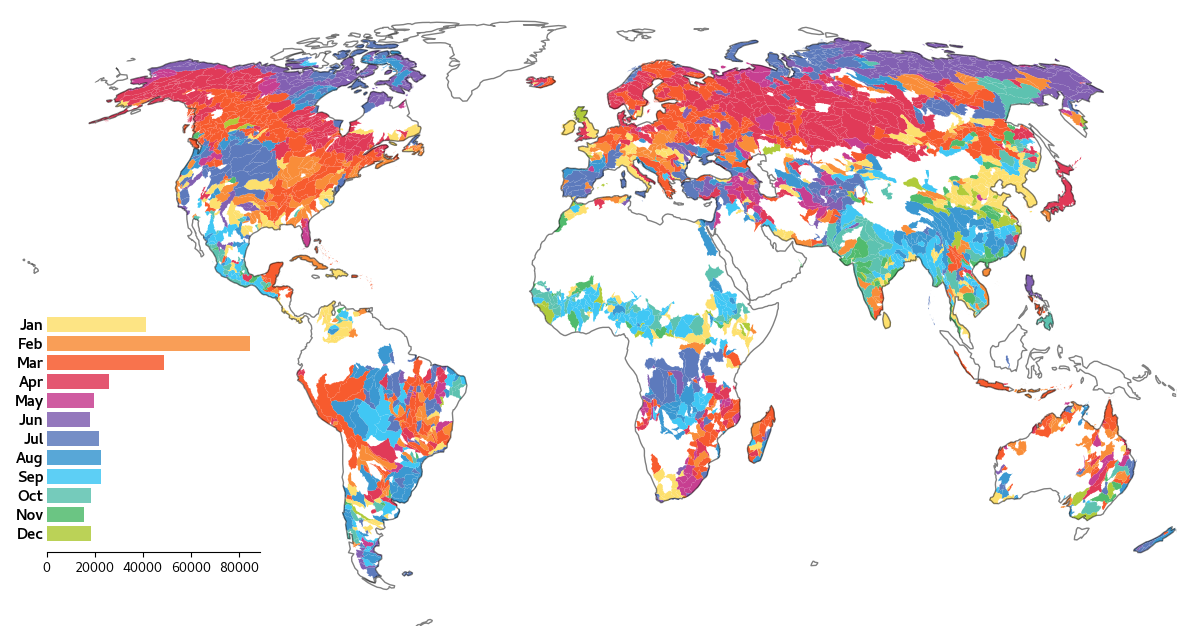

In [210]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the color palette for months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#FDE06E', '#F98D39', '#F75B2E', '#E03A58', '#C73F91', '#8260B2', 
          '#5d7abc', '#3b98d1', '#40c7f4', '#5dc2b0', '#51bb6d', '#b0cb3a']
cmap_custom = mcolors.ListedColormap(colors)

# Create the main plot with Robinson projection
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.Robinson()})

# Set map extent and add coastlines
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([-160, 160, -65, 90], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, alpha=0.5)
ax.set_frame_on(False)

# Plot world_subcatchments colored by 'modal_peak_month'
world_subcatchments.plot(column='modal_peak_month', cmap=cmap_custom, ax=ax, 
                         transform=ccrs.PlateCarree(), legend=False)

# Set up the bar chart for modal counts by month
axins = inset_axes(ax, width="47%", height="20%", 
                   bbox_to_anchor=(-0.072, -0.68, 0.39, 2), bbox_transform=ax.transAxes, loc='center')

# Count each peak month for sine_peaks_df
value_counts = filtered_gdf_sine['int_month'].value_counts()
value_counts_dict = value_counts.to_dict()

value_counts_dict.pop('No clear peak', None)
value_counts_dict.pop('never 8 months', None)

peak_month_data = {int(float(k)): v for k, v in value_counts_dict.items()}
month_counts = [peak_month_data.get(i, 0) for i in range(1, 13)]  # Handle missing months

# Plot the bar chart with horizontal orientation
bars = axins.barh(months[::-1], month_counts[::-1], color=colors[::-1], alpha=0.85)

# Label each bar with the month name on the right side
for i, bar in enumerate(bars):
    # axins.text(bar.get_width()*0 + 100, bar.get_y() + 0.3, months[::-1][i], va='center', ha='left', fontsize=11, color='black')
    axins.text(-1200, bar.get_y() + 0.3, months[::-1][i], va='center', ha='right', fontsize=11, color='black', fontweight='bold')


# Customize inset chart style
axins.patch.set_alpha(0.0)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['left'].set_visible(False)

# # Add a white background with alpha=0.5 and black border to the inset axes
# rect = plt.Rectangle((-0.1, 0), 1.1, 1, transform=axins.transAxes, color='white', alpha=0.8, zorder=-1)
# axins.add_patch(rect)


# Remove x-axis label and hide y-axis labels
axins.set_xlabel('')
axins.xaxis.set_visible(True)
axins.yaxis.set_visible(False)
axins.tick_params(axis='x', labelsize=10)

# Show the plot
plt.show()


In [177]:

# Count each peak month for sine_peaks_df
value_counts = filtered_gdf_sine['int_month'].value_counts()
value_counts_dict = value_counts.to_dict()

value_counts_dict.pop('No clear peak', None)
value_counts_dict.pop('never 8 months', None)

peak_month_data = {int(float(k)): v for k, v in value_counts_dict.items()}
month_counts = [peak_month_data.get(i, 0) for i in range(1, 13)]  # Handle missing months
month_counts

[41405,
 84760,
 48915,
 25864,
 19931,
 18265,
 21737,
 22784,
 22807,
 18546,
 15521,
 18455]

In [178]:
filtered_gdf_direct = combined_raw_seasonality_sin_gdf[
    ~combined_raw_seasonality_sin_gdf['Direct Peak Month'].isin([np.nan, "No clear peak", "never 8 months"])
].copy()


In [179]:
import geopandas as gpd
import pandas as pd
from scipy import stats

# Spatial join to assign each point to a polygon in world_subcatchments
joined = gpd.sjoin(filtered_gdf_direct, world_subcatchments, how="left", op="intersects")

# Perform modal analysis to find the most common peak month per subcatchment
modal_results = joined.groupby('index_right')['Direct Peak Month'].agg(lambda x: stats.mode(x)[0][0])

# Assign modal peak month to world_subcatchments
world_subcatchments['modal_peak_month'] = modal_results

# Count occurrences for each subcatchment
counts = joined.groupby('index_right').size()
world_subcatchments['count_peak_month'] = counts
world_subcatchments['count_peak_month'] = world_subcatchments['count_peak_month'].fillna(0).astype(int)

world_subcatchments = world_subcatchments[world_subcatchments['Area_by_point'] < 1000].copy()

In [180]:
modal_results.value_counts()

Direct Peak Month
3.0     715
2.0     296
4.0     286
9.0     259
1.0     185
8.0     174
10.0    160
5.0     101
7.0      97
6.0      88
11.0     84
12.0     39
Name: count, dtype: int64

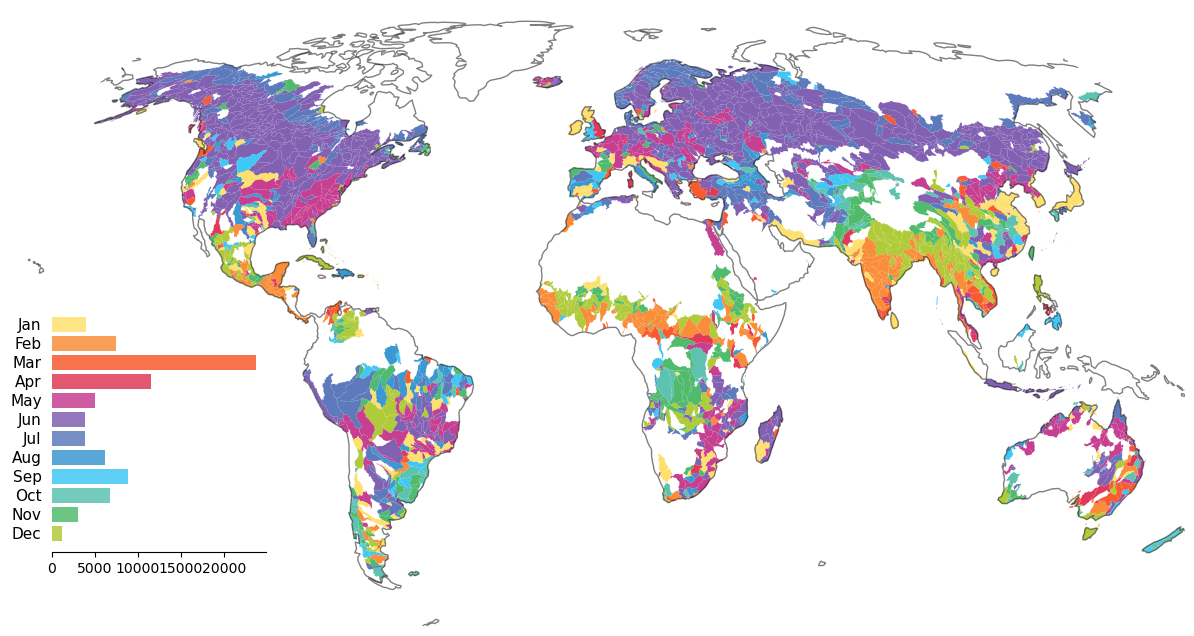

In [181]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the color palette for months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#FDE06E', '#F98D39', '#F75B2E', '#E03A58', '#C73F91', '#8260B2', 
          '#5d7abc', '#3b98d1', '#40c7f4', '#5dc2b0', '#51bb6d', '#b0cb3a']
cmap_custom = mcolors.ListedColormap(colors)

# Create the main plot with Robinson projection
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.Robinson()})

# Set map extent and add coastlines
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([-160, 160, -65, 90], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, alpha=0.5)

# Plot world_subcatchments colored by 'modal_peak_month'
world_subcatchments.plot(column='modal_peak_month', cmap=cmap_custom, ax=ax, 
                         transform=ccrs.PlateCarree(), legend=False)
ax.set_frame_on(False)

# Set up the bar chart for modal counts by month
axins = inset_axes(ax, width="47%", height="20%", 
                   bbox_to_anchor=(-0.072, -0.68, 0.39, 2), bbox_transform=ax.transAxes, loc='center')

# Count each peak month for sine_peaks_df
value_counts = filtered_gdf_direct['Direct Peak Month'].value_counts()
value_counts_dict = value_counts.to_dict()

value_counts_dict.pop('No clear peak', None)
value_counts_dict.pop('never 8 months', None)

peak_month_data = {int(float(k)): v for k, v in value_counts_dict.items()}
month_counts = [peak_month_data.get(i, 0) for i in range(1, 13)]  # Handle missing months

# Plot the bar chart with horizontal orientation
bars = axins.barh(months[::-1], month_counts[::-1], color=colors[::-1], alpha=0.85)

# Label each bar with the month name on the right side
for i, bar in enumerate(bars):
    # axins.text(bar.get_width()*0 + 100, bar.get_y() + 0.3, months[::-1][i], va='center', ha='left', fontsize=11, color='black')
    axins.text(-1200, bar.get_y() + 0.33, months[::-1][i], va='center', ha='right', fontsize=11, color='black')


# Customize inset chart style
axins.patch.set_alpha(0.0)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['left'].set_visible(False)

# # Add a white background with alpha=0.5 and black border to the inset axes
# rect = plt.Rectangle((-0.1, 0), 1.1, 1, transform=axins.transAxes, color='white', alpha=0.8, zorder=-1)
# axins.add_patch(rect)


# Remove x-axis label and hide y-axis labels
axins.set_xlabel('')
axins.xaxis.set_visible(True)
axins.yaxis.set_visible(False)
axins.tick_params(axis='x', labelsize=10)

# Show the plot
plt.show()


In [182]:
month_counts

[3941, 7399, 23721, 11550, 5028, 3827, 3869, 6121, 8819, 6710, 2988, 1129]

In [183]:
filtered_gdf_direct['COMID'].value_counts()

COMID
14025640    3
74037032    3
62069078    3
81036145    3
44023374    3
           ..
31051612    1
31051602    1
31051593    1
31051590    1
83023498    1
Name: count, Length: 84980, dtype: int64

## Get Discharge Peaks

In [184]:
import pandas as pd

# Load the parquet file
file_path = 'NCDF_out/ERA5nc/2mTemperature.parquet'
data = pd.read_parquet(file_path)

In [185]:
import geopandas as gpd
from netCDF4 import Dataset, num2date
import pandas as pd

# Load the GeoDataFrame (assuming it's already loaded as gdf_sine_nonsine_peaks)
gdf_sine_nonsine_peaks = gpd.read_file("NCDF_out/sine nonsine peak 479595.gpkg")
sorted_comids = sorted(gdf_sine_nonsine_peaks['COMID'].tolist())

# Filter COMIDs starting with digits from '1' to '8'
comid_groups = {str(i): [comid for comid in sorted_comids if str(comid).startswith(str(i))] for i in range(1, 9)}

# Define file paths for each range
file_paths = {
    '1': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_01_1979-2019.nc",
    '2': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_02_1979-2019.nc",
    '3': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_03_1979-2019.nc",
    '4': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_04_1979-2019.nc",
    '5': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_05_1979-2019.nc",
    '6': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_06_1979-2019.nc",
    '7': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_07_1979-2019.nc",
    '8': "/N/lustre/project/proj-212/Dongmei/globalQ/HRR/GRADES/data/GRFR/discharge/output_pfaf_08_1979-2019.nc"
}

In [186]:
from netCDF4 import Dataset, num2date
from tqdm import tqdm
import numpy as np
import pandas as pd
from datetime import datetime
year1 = '1979'
year2 = '2019'

region_peakmonth_df = []

for region in comid_groups.keys():
    print("\n Region", region, "Processing: \n")
    
    comid_list = comid_groups[region]
    file_path = file_paths[region]

    with Dataset(file_path, mode='r') as nc_file:
        
        # Extract the variable Qout and relevant dimensions
        qout = nc_file.variables['Qout'][:]
        rivids = nc_file.variables['rivid'][:]
        time_var = nc_file.variables['time']
        times = num2date(time_var[:], units=time_var.units, calendar='standard')
        print('Extracted Raw')

        # Create a time mask for the year 2019
        start_date = datetime(1979, 1, 1)
        dates = pd.date_range(start=start_date, periods=len(times))
        mask_2019 = (dates >= year1 + '-01-01') & (dates <= year2 + '-12-31')
        dates_2019 = dates[mask_2019]
        df_dates_2019 = pd.DataFrame({'Date': dates_2019})
        df_dates_2019['Month'] = df_dates_2019['Date'].dt.month
        print('1979-2019 data extracted')

        # Select Qout data for 2019
        qout_2019 = qout[mask_2019, :]  # Shape (365, 647946) for 2019

        # Calculate monthly means
        monthly_means = np.zeros((12, qout_2019.shape[1]))  # Shape (12, 647946)
        print('Extract Monthly means')

        for month in range(1, 13):
            month_mask = df_dates_2019['Month'] == month
            monthly_means[month - 1, :] = qout_2019[month_mask, :].mean(axis=0)

        # Find the month with the maximum average for each column
        month_with_max_average = np.argmax(monthly_means, axis=0) + 1  # 1-indexed (Jan=1, Feb=2, etc.)

        # Map the peak month to each COMID
        df_peak_month = pd.DataFrame({
            'COMID': rivids,
            'NC Peak Month': month_with_max_average
        })

        region_peakmonth_df.append(df_peak_month)



 Region 1 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 2 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 3 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 4 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 5 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 6 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 7 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means

 Region 8 Processing: 

Extracted Raw
1979-2019 data extracted
Extract Monthly means


In [187]:
all_peak_month_df = pd.concat(region_peakmonth_df, ignore_index=True)
all_peak_month_df.rename(columns={'Peak Month': 'NC Peak Month'}, inplace=True)

In [188]:
import geopandas as gpd
gdf_sine_nonsine_nc_peaks = gdf_sine_nonsine_peaks.merge(all_peak_month_df[['COMID', 'NC Peak Month']], on='COMID', how='inner')

In [189]:
# Define the circular month difference function with directional output
def circular_month_difference_directional(month1, month2):
    # Calculate clockwise and counterclockwise differences
    clockwise_difference = (month2 - month1) % 12
    counterclockwise_difference = (month1 - month2) % 12
    
    # Determine the signed difference
    if clockwise_difference <= counterclockwise_difference:
        return clockwise_difference  # Positive for clockwise
    else:
        return -counterclockwise_difference  # Negative for counterclockwise

gdf_sine_nonsine_nc_peaks['circular_sine'] = gdf_sine_nonsine_nc_peaks.apply(lambda row: circular_month_difference_directional(row['sine peak fin'], row['NC Peak Month']), axis=1)
gdf_sine_nonsine_nc_peaks['circular_direct'] = gdf_sine_nonsine_nc_peaks.apply(lambda row: circular_month_difference_directional(row['non sine peak'], row['NC Peak Month']), axis=1)


In [190]:
# Create 'fin nc close peak' column based on the condition
gdf_sine_nonsine_nc_peaks['fin nc close peak'] = np.where(
    abs(gdf_sine_nonsine_nc_peaks['circular_direct']) > abs(gdf_sine_nonsine_nc_peaks['circular_sine']),
    gdf_sine_nonsine_nc_peaks['sine peak fin'],
    gdf_sine_nonsine_nc_peaks['non sine peak']
)

gdf_sine_nonsine_nc_peaks['circular_merged'] = gdf_sine_nonsine_nc_peaks.apply(lambda row: circular_month_difference_directional(row['fin nc close peak'], row['NC Peak Month']), axis=1)


In [191]:
output_path = "NCDF_out/sine nonsine nc peak 479595 updated.gpkg"
gdf_sine_nonsine_nc_peaks.to_file(output_path, driver="GPKG")

In [192]:
gdf_sine_nonsine_nc_peaks = gpd.read_file("NCDF_out/sine nonsine nc peak 479595 updated.gpkg")

In [193]:
gdf_sine_nonsine_nc_peaks

COMID  non sine peak  sine peak  sine_fit        lat        lon  \
0       11002347            8.0          9         0  19.820651  36.922500   
1       11002574            4.0          1         1  19.606522  37.222355   
2       11002692           10.0          2         1  20.128790  37.209167   
3       11003295           10.0          1         0  18.086689  38.460811   
4       11004447           10.0         11         1  16.000856  37.407500   
...          ...            ...        ...       ...        ...        ...   
479591  86007034            NaN          7         0  74.925508 -93.407500   
479592  86007071            NaN          5         0  74.747500 -95.048262   
479593  86007124            NaN          5         0  74.673333 -94.203116   
479594  86007168            NaN          6         0  74.565833 -95.322518   
479595  86007176            NaN          8         0  74.584803 -95.679167   

        sine peak fin  NC Peak Month  circular_sine  circular_direct  \
0                 NaN              8            NaN              0.0   
1                 1.0             11           -2.0             -5.0   
2                 2.0             11           -3.0              1.0   
3                 NaN             11            NaN              1.0   
4                11.0              8           -3.0             -2.0   
...               ...            ...            ...              ...   
479591            NaN              6            NaN              NaN   
479592            NaN              6            NaN              NaN   
479593            NaN              6            NaN              NaN   
479594            NaN              6            NaN              NaN   
479595            NaN              6            NaN              NaN   

        fin nc close peak  circular_merged                    geometry  
0                     8.0              0.0   POINT (36.92250 19.82065)  
1                     1.0             -2.0   POINT (37.22235 19.60652)  
2                    10.0              1.0   POINT (37.20917 20.12879)  
3                    10.0              1.0   POINT (38.46081 18.08669)  
4                    10.0             -2.0   POINT (37.40750 16.00086)  
...                   ...              ...                         ...  
479591                NaN              NaN  POINT (-93.40750 74.92551)  
479592                NaN              NaN  POINT (-95.04826 74.74750)  
479593                NaN              NaN  POINT (-94.20312 74.67333)  
479594                NaN              NaN  POINT (-95.32252 74.56583)  
479595                NaN              NaN  POINT (-95.67917 74.58480)  

[479596 rows x 13 columns]

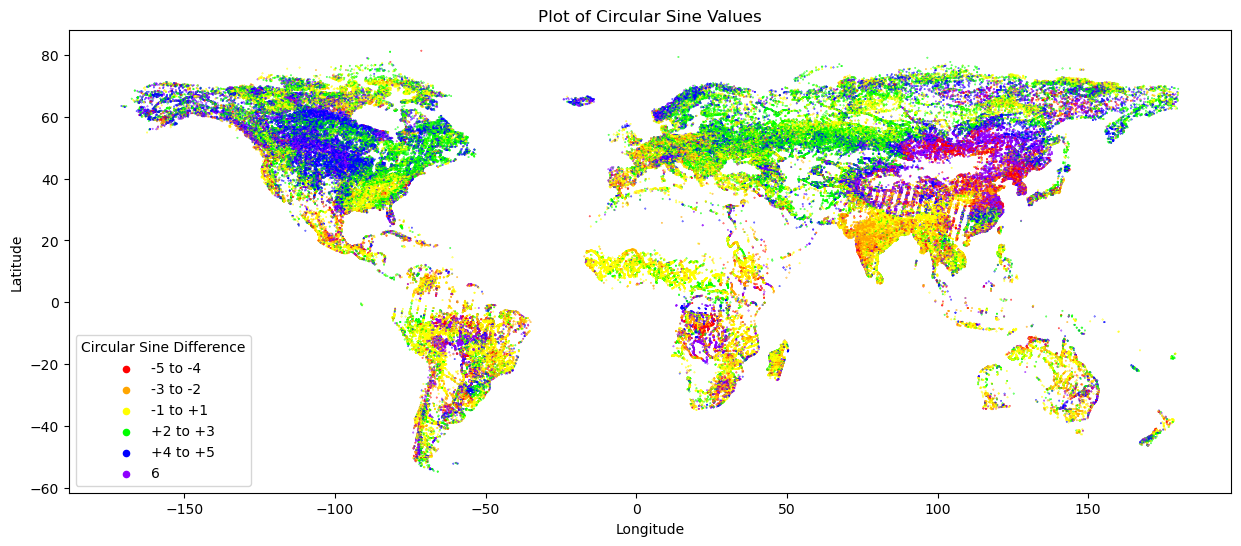

In [194]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Filter out rows where 'circular_sine' is NaN
gdf_plot = gdf_sine_nonsine_nc_peaks.dropna(subset=['circular_sine'])

# Create a GeoDataFrame for plotting
gdf_plot = gpd.GeoDataFrame(
    gdf_plot, 
    geometry=gpd.points_from_xy(gdf_plot['lon'], gdf_plot['lat']),
    crs="EPSG:4326"
)

# Define the color map and custom legend
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#0000FF', "#8F00FF"]  # Custom colors
cmap = mcolors.ListedColormap(colors)
legend_labels = ['-5 to -4', '-3 to -2', '-1 to +1', '+2 to +3', '+4 to +5', '6']

# Classify 'circular_sine' into custom bins for color mapping
bins = [-np.inf, -4, -2, 1, 3, 5, np.inf]
gdf_plot['sine_category'] = np.digitize(gdf_plot['circular_sine'], bins) - 1  # Adjust to match index with colors

# Plotting with smaller markers
fig, ax = plt.subplots(figsize=(15, 12))
gdf_plot.plot(column='sine_category', cmap=cmap, legend=False, ax=ax, markersize=0.1)  # Reduced markersize for smaller dots

# Custom legend
for i, label in enumerate(legend_labels):
    ax.scatter([], [], color=colors[i], label=label, s=20)  # Adjust legend marker size if needed

ax.legend(title="Circular Sine Difference")
plt.title('Plot of Circular Sine Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


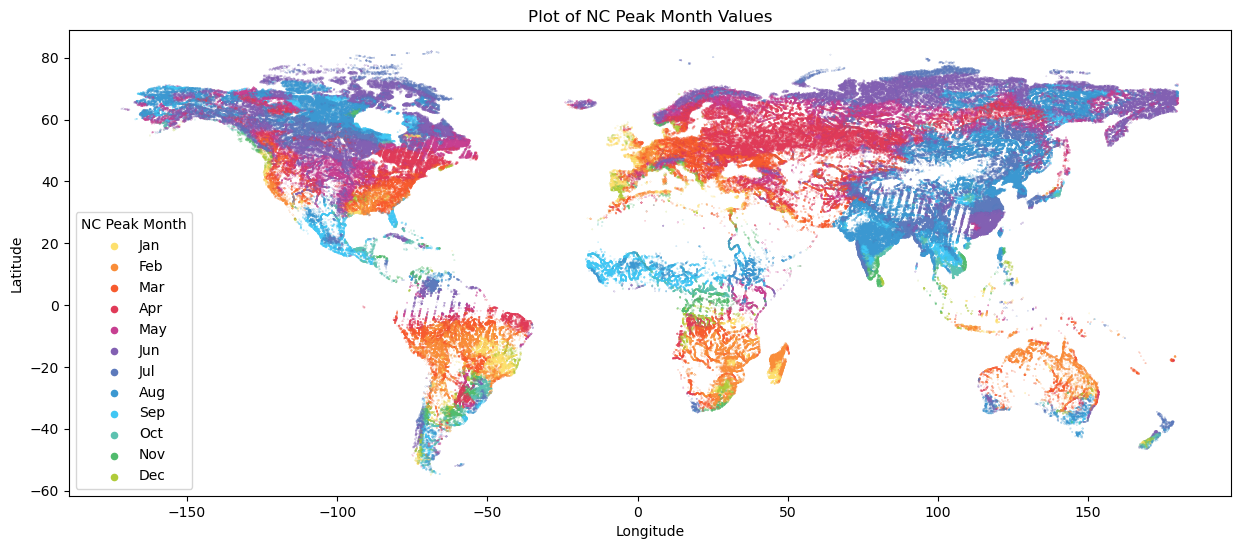

In [195]:
# Filter out rows where 'NC Peak Month' is NaN
gdf_plot = gdf_sine_nonsine_nc_peaks.dropna(subset=['NC Peak Month'])

# Create a GeoDataFrame for plotting
gdf_plot = gpd.GeoDataFrame(
    gdf_plot, 
    geometry=gpd.points_from_xy(gdf_plot['lon'], gdf_plot['lat']),
    crs="EPSG:4326"
)

# Define the color map and custom legend
colors = ['#FDE06E', '#F98D39', '#F75B2E', '#E03A58', '#C73F91', '#8260B2', 
          '#5d7abc', '#3b98d1', '#40c7f4', '#5dc2b0', '#51bb6d', '#b0cb3a']
cmap = mcolors.ListedColormap(colors)
legend_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting with markers
fig, ax = plt.subplots(figsize=(15, 12))
gdf_plot.plot(column='NC Peak Month', cmap=cmap, legend=False, ax=ax, markersize=0.01)  # Adjust markersize as needed

# Custom legend
for i, label in enumerate(legend_labels):
    ax.scatter([], [], color=colors[i], label=label, s=20)  # Adjust size for legend markers if needed

ax.legend(title="NC Peak Month")
plt.title('Plot of NC Peak Month Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


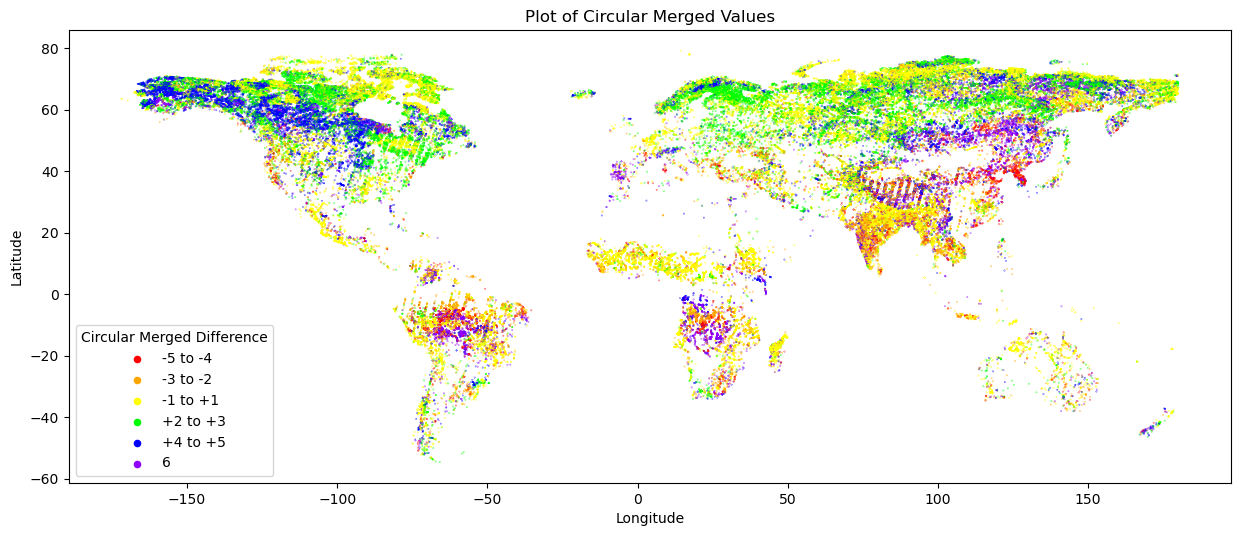

In [196]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Filter out rows where 'circular_sine' is NaN
gdf_plot = gdf_sine_nonsine_nc_peaks.dropna(subset=['circular_merged'])

# Create a GeoDataFrame for plotting
gdf_plot = gpd.GeoDataFrame(
    gdf_plot, 
    geometry=gpd.points_from_xy(gdf_plot['lon'], gdf_plot['lat']),
    crs="EPSG:4326"
)

# Define the color map and custom legend
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#0000FF', "#8F00FF"]  # Custom colors
cmap = mcolors.ListedColormap(colors)
legend_labels = ['-5 to -4', '-3 to -2', '-1 to +1', '+2 to +3', '+4 to +5', '6']

# Classify 'circular_sine' into custom bins for color mapping
bins = [-np.inf, -4, -2, 1, 3, 5, np.inf]
gdf_plot['merged_category'] = np.digitize(gdf_plot['circular_merged'], bins) - 1  # Adjust to match index with colors

# Plotting with smaller markers
fig, ax = plt.subplots(figsize=(15, 12))
gdf_plot.plot(column='merged_category', cmap=cmap, legend=False, ax=ax, markersize=0.05)  # Reduced markersize for smaller dots

# Custom legend
for i, label in enumerate(legend_labels):
    ax.scatter([], [], color=colors[i], label=label, s=20)  # Adjust legend marker size if needed

ax.legend(title="Circular Merged Difference")
plt.title('Plot of Circular Merged Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [197]:
gdf_points = gdf_sine_nonsine_nc_peaks.dropna(subset=['fin nc close peak']).copy()

#### Note we have used the new climate classification, and removed nodata features

In [198]:
import geopandas as gpd
import pandas as pd
from scipy import stats

# Load shapefile for world subcatchments
world_subcatchments = gpd.read_file("NCDF_out/world_subcatchments updated.gpkg")

# Convert sine_peaks_df to a GeoDataFrame
gdf_points.crs = "EPSG:4326"  # Ensure CRS compatibility

# Spatial join to assign each point to a polygon in world_subcatchments
joined = gpd.sjoin(gdf_plot, world_subcatchments, how="left", op="within")

# Perform modal analysis to find the most common peak month per subcatchment
modal_results = joined.groupby('index_right')['fin nc close peak'].agg(lambda x: stats.mode(x)[0][0])
peak_counts = joined.groupby('index_right')['fin nc close peak'].value_counts()

# Assign modal peak month to world_subcatchments
world_subcatchments['modal_peak_month'] = modal_results
peak_counts_df = peak_counts.reset_index(name='count')

# Count occurrences for each subcatchment
counts = joined.groupby('index_right').size()
world_subcatchments['count_peak_month'] = counts
world_subcatchments['count_peak_month'] = world_subcatchments['count_peak_month'].fillna(0).astype(int)

# Calculate Area_by_point with a conditional check for point_count
# world_subcatchments['Area_by_point'] = np.where(
#     world_subcatchments['point_count'] == 0,  # Condition: point_count is 0
#     0,  # Value if condition is true
#     world_subcatchments['SUB_AREA'] / world_subcatchments['point_count']  # Value if condition is false
# )

# world_subcatchments.loc[world_subcatchments['Area_by_point'] >= 1000, 'modal_peak_month'] = None

In [199]:
world_subcatchments = world_subcatchments[world_subcatchments['sin_season_mode'] != 'No Data']

In [200]:
world_subcatchments.head(3)

HYBAS_ID   NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
26  1050008100           0  1050008100  1050008100        0.0        0.0   
27  1051144990  1050008100  1050008100  1050008100       29.6       29.6   
30  1051139430  1051144990  1050008100  1050008100       74.1       74.1   

    SUB_AREA   UP_AREA  PFAF_ID  ENDO  COAST  ORDER  SORT               layer  \
26    1426.2  745374.3    11410     0      0      1    27  hybas_af_lev05_v1c   
27     619.5  513314.0    11430     0      0      1    28  hybas_af_lev05_v1c   
30   49429.4  214441.4    11441     0      0      2    31  hybas_af_lev05_v1c   

      sin_season_mode  point_count  Area_by_point  \
26       Non Seasonal          6.0     237.700000   
27  Non-Sine Seasonal          8.0      77.437500   
30  Non-Sine Seasonal        106.0     466.315094   

                                             geometry  modal_peak_month  \
26  POLYGON ((42.78333 -0.07083, 42.78277 -0.07304...               1.0   
27  POLYGON ((42.65000 0.26667, 42.65000 0.25417, ...               1.0   
30  POLYGON ((42.27083 1.45833, 42.27146 1.46992, ...               1.0   

    count_peak_month  
26                 1  
27                 2  
30                33

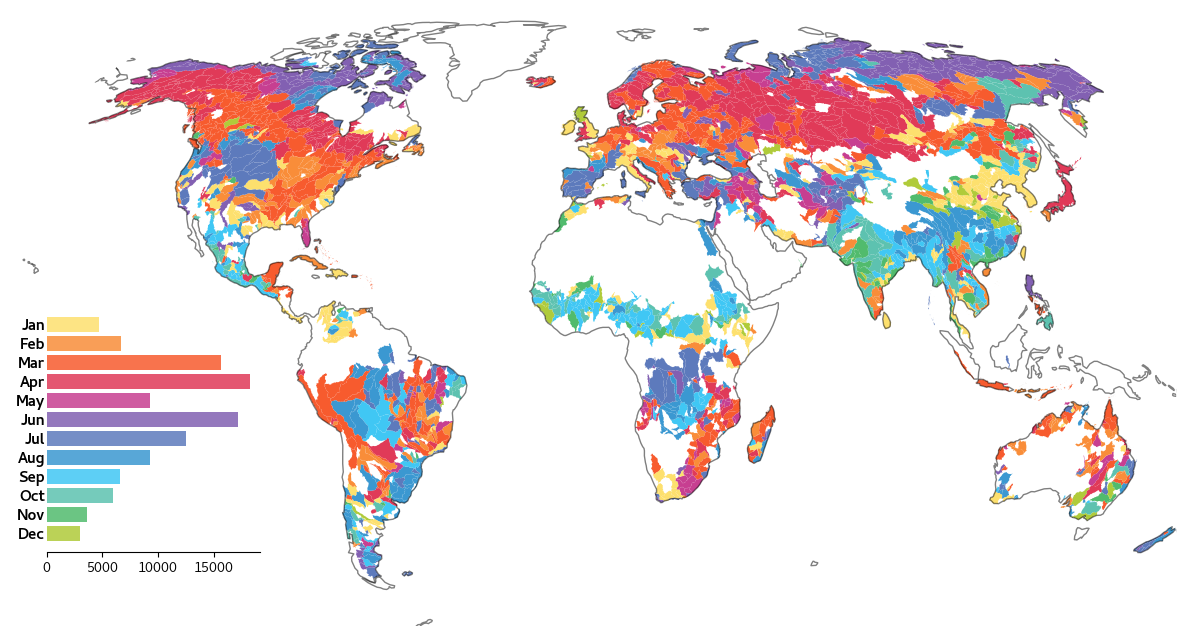

In [211]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the color palette for months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#FDE06E', '#F98D39', '#F75B2E', '#E03A58', '#C73F91', '#8260B2', 
          '#5d7abc', '#3b98d1', '#40c7f4', '#5dc2b0', '#51bb6d', '#b0cb3a']
cmap_custom = mcolors.ListedColormap(colors)

# Create the main plot with Robinson projection
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.Robinson()})

# Set map extent and add coastlines
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_extent([-160, 160, -65, 90], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, alpha=0.5)

# Plot world_subcatchments colored by 'modal_peak_month'
world_subcatchments.plot(column='modal_peak_month', cmap=cmap_custom, ax=ax, 
                         transform=ccrs.PlateCarree(), legend=False)
ax.set_frame_on(False)

# Set up the bar chart for modal counts by month
axins = inset_axes(ax, width="47%", height="20%", 
                   bbox_to_anchor=(-0.072, -0.68, 0.39, 2), bbox_transform=ax.transAxes, loc='center')

# Count each peak month for sine_peaks_df
value_counts = gdf_points['fin nc close peak'].value_counts()
value_counts_dict = value_counts.to_dict()
peak_month_data = {k: v for k, v in value_counts_dict.items()}
month_counts = [peak_month_data.get(i, 0) for i in range(1, 13)]  # Handle missing months

# Plot the bar chart with horizontal orientation
bars = axins.barh(months[::-1], month_counts[::-1], color=colors[::-1], alpha=0.85)

# Label each bar with the month name on the right side
for i, bar in enumerate(bars):
    # axins.text(bar.get_width()*0 + 100, bar.get_y() + 0.3, months[::-1][i], va='center', ha='left', fontsize=11, color='black')
    axins.text(-120, bar.get_y() + 0.3, months[::-1][i], va='center', ha='right', fontsize=11, color='black', fontweight='bold')


# Customize inset chart style
axins.patch.set_alpha(0.0)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['left'].set_visible(False)

# # Add a white background with alpha=0.5 and black border to the inset axes
# rect = plt.Rectangle((-0.1, 0), 1.1, 1, transform=axins.transAxes, color='white', alpha=0.8, zorder=-1)
# axins.add_patch(rect)

# Remove x-axis label and hide y-axis labels
axins.set_xlabel('')
axins.xaxis.set_visible(True)
axins.yaxis.set_visible(False)
axins.tick_params(axis='x', labelsize=10)


# Show the plot
plt.show()


### Make Figure 4

In [202]:
plt.rcParams["font.family"] = "Cantarell"

In [203]:
from dbfread import DBF
import pandas as pd

dbf_path = 'NCDF_out/sine nonsine nc peak 479595.dbf'
table = DBF(dbf_path)
COMID_LatLon = pd.DataFrame(iter(table))

In [204]:
merged_seasonality_wLatLon = merged_seasonality_df.merge(COMID_LatLon[['COMID', 'lat', 'lon']], on='COMID', how='left')

In [205]:
df = gdf_plot

In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bins = [-60, -30, 0, 30, 60, 90]
bin_labels = ['-60° to -30°', '-30° to 0°', '0° to 30°', '30° to 60°', '60° to 90°']

gdf_join_seasonality_sine_steady_df = merged_seasonality_wLatLon

# Bin the latitudes in gdf_join_seasonality_sine_steady_df based on specified bins
gdf_join_seasonality_sine_steady_df['lat_bin'] = pd.cut(
    gdf_join_seasonality_sine_steady_df['lat'], bins=bins, labels=bin_labels, include_lowest=True
)

# Calculate count and percentage for each unique value in sin_ssn_stdy column within each latitude bin
results = []
for label in bin_labels:
    bin_data = gdf_join_seasonality_sine_steady_df[gdf_join_seasonality_sine_steady_df['lat_bin'] == label]
    value_counts = bin_data['Seasonality'].value_counts()
    total_count = value_counts.sum()
    percentage_counts = (value_counts / total_count * 100).round(2)
    
    # Store results in a DataFrame for easy display
    bin_results = pd.DataFrame({
        'Value': value_counts.index,
        'Count': value_counts.values,
        'Percentage': percentage_counts.values
    })
    bin_results['Latitude Bin'] = label
    results.append(bin_results)

# Concatenate all bin results for display
final_results = pd.concat(results, ignore_index=True)

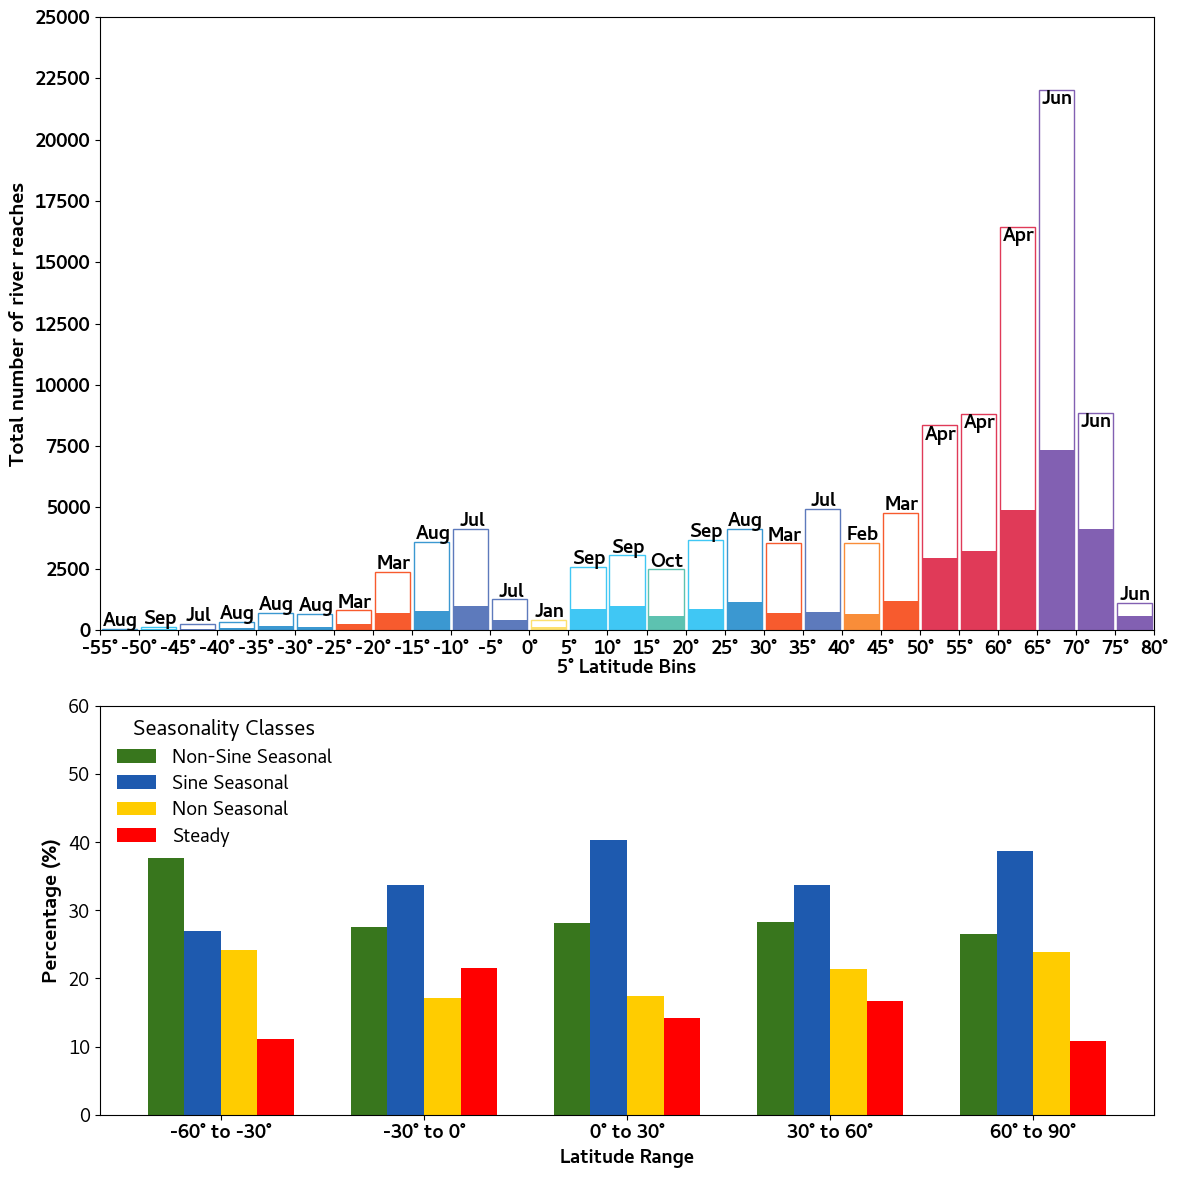

In [207]:
# Set font size and weight
text_size = 14
plt.rcParams.update({'font.size': text_size, 'font.weight': 'normal'})

# Define bins, month names, and colors
bins = np.arange(-55, 85, 5)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#FDE06E', '#F98D39', '#F75B2E', '#E03A58', '#C73F91', '#8260B2', 
          '#5d7abc', '#3b98d1', '#40c7f4', '#5dc2b0', '#51bb6d', '#b0cb3a']

# Create latitude bins and calculate mode and count by latitude bin
df['lat_bin'] = pd.cut(df['lat'], bins=bins)
mode_counts = df.groupby('lat_bin')['fin nc close peak'].agg(
    lambda x: (x.mode()[0], (x == x.mode()[0]).sum()) if not x.mode().empty else (None, 0)
)
mode_peak_month = mode_counts.apply(lambda x: x[0])  # Mode values
mode_peak_counts = mode_counts.apply(lambda x: x[1])  # Mode counts
counts = df.groupby('lat_bin')['lat'].count()

# Calculate bin midpoints for bar positions
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Plot setup for top-bottom configuration with 60%-40% height distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 2]})

# Top Plot: Hatched outline with color fill up to mode peak counts
for midpoint, count, mode, mode_count in zip(bin_midpoints, counts, mode_peak_month, mode_peak_counts):
    if mode is not None:
        mode = int(mode)
        color = colors[mode - 1]
        # Outline bar for the total count with hatch and color matching mode color
        ax1.bar(midpoint, count, width=4.5, color='none', edgecolor=color, align='center')
        
        # Filled bar up to mode count
        ax1.bar(midpoint, mode_count, width=4.5, color=color, edgecolor='none', align='center')

        # Add month annotation
        month_name = months[mode - 1]

        if count < 5000:
            ax1.text(midpoint + 0.15, count + 300, month_name, ha='center', va='center', color='black', fontsize=text_size, fontweight='bold')
        else:
            ax1.text(midpoint + 0.15, count - 400, month_name, ha='center', va='center', color='black', fontsize=text_size, fontweight='bold')

ax1.set_xlim(-55, 80)  # Set the x-axis 
ax1.set_ylim(0, 25000)  # Set the y-axis range from 0 to 22500
ax1.set_yticks(np.arange(0, 25001, 2500))  # Set major ticks at intervals of 2500

# Label axis
ax1.tick_params(axis='y', labelsize=text_size)  # Set tick label size
ax1.set_yticklabels([f"{int(t)}" for t in np.arange(0, 25001, 2500)], fontweight='bold')  # Set tick label font weight

ax1.tick_params(axis='x', labelsize=text_size)
ax1.set_xlabel('5° Latitude Bins', fontsize=text_size, fontweight='bold', labelpad=0)
ax1.set_ylabel('Total number of river reaches', fontsize=text_size + 1, fontweight='bold')

# Latitude bin tick labels with degree symbol
lat_labels = [f"{int(b)}°" for b in bins]
ax1.set_xticks(bins)
ax1.set_xticklabels(lat_labels, rotation=0, ha='center', fontsize=text_size, fontweight='bold')

# Bottom Plot: Seasonality class percentages by latitude range
bin_labels = ['-60° to -30°', '-30° to 0°', '0° to 30°', '30° to 60°', '60° to 90°']
latitude_bins = final_results['Latitude Bin'].unique()
values = final_results['Value'].unique()
bar_width = 0.18
index = np.arange(len(latitude_bins))
bold_color_map = {
    'Sine Seasonal': '#1E5AAF',      # Bolder Blue
    'Non-Sine Seasonal': '#38761D',  # Bolder Green
    'Non Seasonal': '#FFCC00',       # Bolder Yellow
    'Steady': 'red',                 # Red
    'No Data': '#B3B3B3'             # Bolder Grey
}

for i, value in enumerate(values):
    color = bold_color_map.get(value, '#d3d3d3')
    percentages = final_results[final_results['Value'] == value].set_index('Latitude Bin').reindex(latitude_bins)['Percentage'].fillna(0)
    ax2.bar(index + i * bar_width, percentages, bar_width, label=value, color=color)

# Customize ax2 with black labels and other style settings
ax2.set_xticks(index + bar_width * (len(values) - 1) / 2)
ax2.set_xticklabels(latitude_bins, rotation=0, ha='center', color='#000000', fontsize=text_size, fontweight='bold')
ax2.set_xlabel('Latitude Range', fontsize=text_size, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=text_size + 1, fontweight='bold')
ax2.set_ylim(0, 60)
ax2.legend(title='Seasonality Classes', loc='upper left', labelspacing=0.35, bbox_to_anchor=(0.0, 1.01), frameon=False, fontsize=text_size, title_fontsize=text_size + 1.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


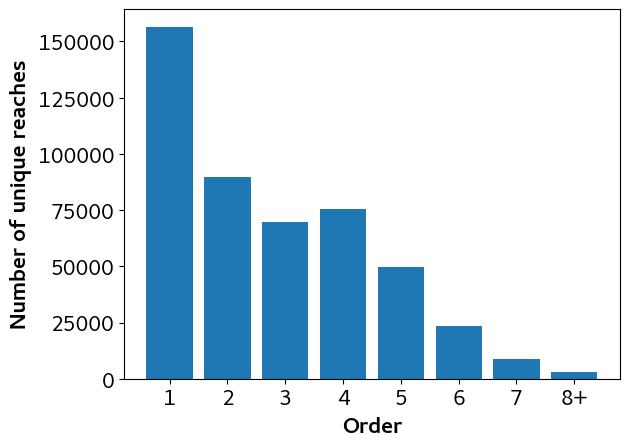

In [240]:
order = ['1', '2', '3', '4', '5', '6', '7', '8+']
unique_comid_count_list = [156573, 89867, 69492, 75507, 49757, 23386, 8574, 3090]
total_observations_count_list = [224586683,
 176659011,
 219774726,
 336281066,
 262838147,
 121567602,
 42159967,
 16847803]

plt.figure()
plt.rcParams['font.size']=16
plt.bar(order, unique_comid_count_list)
plt.xlabel('Order', fontweight='bold')
plt.ylabel('Number of unique reaches', fontweight='bold')
plt.show()

In [ ]:
plt.figure()
plt.rcParams['font.size']=16
plt.bar(order, total_observations_count_list)
plt.xlabel('Order', fontweight='bold')
plt.ylabel('Total number of observations', fontweight='bold')
plt.show()